# BERT - Multi Layer Convolutional Neural Network

Este trabalho tem como objetivo a construção de um modelo de rede neural convolucional multi camada (CNN) para classificação de sentimentos em textos, utilizando o modelo BERT como base para a extração de características. O modelo será treinado e avaliado em um conjunto de dados específico, e os resultados serão apresentados.

In [1]:
import os
import re
import torch
import pandas as pd
from torch.utils.data import DataLoader
from torch.optim import AdamW

from transformers import AutoModel, AutoTokenizer
from transformers import BertModel, BertConfig, ModernBertConfig, ModernBertModel
import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader
import numpy as np

from dataset import HateSpeechDataset

import warnings
warnings.filterwarnings("ignore")

os.environ["TOKENIZERS_PARALLELISM"] = "true"

/Users/i565833/Documents/MSc/Classes/Machine Learning Topics/Work 3 - BERT/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BERT_MODELS = {
    "bert_abaporu": "pablocosta/bertabaporu-base-uncased",
    "bert_timbau": "neuralmind/bert-base-portuguese-cased",
    "tupye_multilabel_bert_base": "Silly-Machine/TuPy-Bert-Base-Multilabel",
    "tupye_multilabel_bert_large": "Silly-Machine/TuPy-Bert-Large-Multilabel",
    "tupye_binary_bert_base": "Silly-Machine/TuPy-Bert-Base-Binary-Classifier",
    "tupye_binary_bert_large": "Silly-Machine/TuPy-Bert-Large-Binary-Classifier"
}

In [3]:
### BERT Classifier
class BertClassifier(torch.nn.Module):
    def __init__(self, num_classes=15, model_name='bert', freeze_bert_layers=False):
        super(BertClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.out = torch.nn.Linear(self.bert.config.hidden_size, num_classes)
        self.freeze_bert_layers = freeze_bert_layers
        if self.freeze_bert_layers:
            print("Freezing BERT layers")
            for param in self.bert.parameters():
                param.requires_grad = False
        else:
            print("Unfreezing BERT layers")
            for param in self.bert.parameters():
                param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.pooler_output
        output = self.dropout(pooled_output)
        return self.out(output)
    
    
### BERT + Multi-Channel CNN Classifier
class BERTMLCNNHateClassifier(torch.nn.Module):
    def __init__(self, model_name, num_classes=2, filter_sizes=(4, 6, 8), num_filters=32, dropout_rate=0.3, freeze_bert_layers=0, classifier_dropout=0.5):
        super(BERTMLCNNHateClassifier, self).__init__()

        # Camada BERT para features globais
        self.bert = AutoModel.from_pretrained(model_name)
        
        # Convoluções para diferentes tamanhos de janela
        self.convs = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Conv1d(self.bert.config.hidden_size, num_filters, kernel_size=fs, padding=fs//2),
                torch.nn.BatchNorm1d(num_filters), # Batch normalization layer
                torch.nn.Dropout(dropout_rate),
                torch.nn.ReLU(),
            )
            for fs in filter_sizes
        ])

        # Camada de pool de max pooling global
        self.global_max_pool = torch.nn.AdaptiveMaxPool1d(1)
        feature_size = len(filter_sizes) * num_filters

        # Classificador final
        self.classifier = torch.nn.Sequential(
            # torch.nn.Linear(feature_size, feature_size // 2),
            # torch.nn.BatchNorm1d(feature_size // 2),
            # torch.nn.ReLU(),
            # torch.nn.Dropout(classifier_dropout),
            torch.nn.Linear(feature_size, num_classes)
        )
        
        # Initialize the model properly
        self.define_trainable_layers(freeze_bert_layers)
        self._initialize_weights()

    def forward(self, input_ids, attention_mask):
        # Pass through BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state.permute(0, 2, 1)

        # Aplicar convoluções e pooling
        conv_outputs = [
            self.global_max_pool(conv(sequence_output)).squeeze(2)  # Reduz para (batch_size, num_filters)
            for conv in self.convs
        ]

        # Concatenar as saídas das convoluções
        features = torch.cat(conv_outputs, dim=1)  # (batch_size, len(filter_sizes) * num_filters)

        # Classificação final
        logits = self.classifier(features)
                
        return logits


    def _initialize_weights(self):
        """Initialize CNN and classifier weights with proper initialization."""
        for name, module in self.named_modules():
            if isinstance(module, torch.nn.Conv1d):
                # He initialization for ReLU
                torch.nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    torch.nn.init.constant_(module.bias, 0)


    def define_trainable_layers(self, freeze_bert_layers=0):
        """
        FIXED: Define which parameters should be trainable.
        
        Args:
            freeze_bert_layers: 
                - 0: Unfreeze all BERT layers
                - >0: Freeze the FIRST N layers (keep last layers trainable)
                - <0: Freeze ALL BERT layers
        """
        if freeze_bert_layers < 0:
            # Freeze all BERT parameters
            print("Freezing ALL BERT layers")
            for param in self.bert.parameters():
                param.requires_grad = False
                
        elif freeze_bert_layers == 0:
            # Unfreeze all BERT parameters
            print("Unfreezing ALL BERT layers")
            for param in self.bert.parameters():
                param.requires_grad = True
                
        elif freeze_bert_layers > 0:
            # Freeze first N layers, keep rest trainable     
            
            # First unfreeze everything
            for param in self.bert.parameters():
                param.requires_grad = True
            
            # Then freeze the first N layers
            layers_to_freeze = min(freeze_bert_layers, len(self.bert.encoder.layer))
            
            # Freeze embeddings
            for param in self.bert.embeddings.parameters():
                param.requires_grad = False
                
            # Freeze first N encoder layers
            for i in range(layers_to_freeze):
                for param in self.bert.encoder.layer[i].parameters():
                    param.requires_grad = False
            
            print(f"Frozen {layers_to_freeze} layers, keeping {len(self.bert.encoder.layer) - layers_to_freeze} layers trainable")
        
        # Always keep CNN and classifier layers trainable
        for param in self.convs.parameters():
            param.requires_grad = True
        for param in self.classifier.parameters():
            param.requires_grad = True
            
        # Print trainable parameter count
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,} ({100*trainable_params/total_params:.1f}%)")

    def get_trainable_params_info(self):
        """Debug method to check which parameters are trainable"""
        trainable_info = {}
        for name, param in self.named_parameters():
            trainable_info[name] = {
                'shape': param.shape,
                'trainable': param.requires_grad,
                'num_params': param.numel()
            }
        return trainable_info

In [4]:
class Trainer:
    """
    Class to train and evaluate a PyTorch model with early stopping and metric tracking.
    """
    def __init__(self, model, dataloader={"train": [], "val": [], "test": []}, epochs=20, criterion=None, optimizer=None, learning_rate=1e-5, gradual_unfreeze=False, unfreeze_epoch=5, device=None, patience=3, class_names=[], best_model_path="./best_model", best_model_filename="best_model.pth", multilabel=False, freeze_bert_layers=0):
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        self.model = model
        self.model.to(self.device)
        # self.model.define_trainable_layers(freeze_bert_layers)
        
        # Dataloaders
        self.dataloader = dataloader

        self.class_names = class_names
        self.num_classes = len(class_names) if class_names else 2  # Default to binary classification if no class names provided
        self.multilabel = multilabel

        if self.multilabel:
            self.criterion = torch.nn.BCEWithLogitsLoss() if criterion is None else criterion
        elif self.num_classes <= 2:
            self.criterion = torch.nn.BCEWithLogitsLoss() if criterion is None else criterion
        else:
            self.criterion = torch.nn.CrossEntropyLoss() if criterion is None else criterion
                

        print(f"Number of classes: {self.num_classes}")
        print(f"Using loss function: {self.criterion.__class__.__name__}")
        
        self.learning_rate = learning_rate

        # Early stopping
        self.patience = patience
        
        self.gradual_unfreeze = gradual_unfreeze
        self.unfreeze_epoch = unfreeze_epoch
        
        self.optimizer = self.define_trainable_parameters()
        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=[learning_rate, learning_rate * 10],
            total_steps=epochs,
            pct_start=0.1,  # 10% warmup
            anneal_strategy='cos'
        )

        # metrics history
        self.history = {
            "train_loss": [], "val_loss": [],
            "train_acc": [], "val_acc": [],
            "train_f1": [], "val_f1": [],
            "train_precision": [], "val_precision": [],
            "train_recall": [], "val_recall": [],
            "train_report": [], "val_report": []
        }
        self.best_val_loss = float('inf')
        self.early_stop_counter = 0

        self.epochs = epochs
        self.best_model_path = best_model_path
        self.best_model_filename = best_model_filename


    def define_trainable_parameters(self):
        """
        Define which parameters of the model should be trainable.
        If freeze_bert_layers > 0, freeze the first N layers of BERT.
        If freeze_bert_layers < 0, freeze all layers of BERT.
        return AdamW(
            optimizer_grouped_parameters,
            lr=self.learning_rate,
            weight_decay=1e-2
        )
        """
        param_optimizer = list(self.model.named_parameters())
    
        # Separate BERT and CNN parameters for different learning rates
        bert_params = []
        cnn_params = []
        
        for name, param in param_optimizer:
            if param.requires_grad:
                if 'bert' in name:
                    bert_params.append(param)
                else:
                    cnn_params.append(param)
        
        # Use different learning rates for different components
        optimizer_grouped_parameters = [
            {
                'params': bert_params,
                'lr': self.learning_rate,  # Lower LR for BERT
                'weight_decay': 1e-2
            },
            {
                'params': cnn_params, 
                'lr': self.learning_rate * 10,  # Higher LR for CNN layers
                'weight_decay': 1e-2
            }
        ]
        
        return AdamW(optimizer_grouped_parameters, eps=1e-8) 


    def check_early_stopping(self, val_loss):
        eps = 2e-5
        improvement = 0.0
        
        # First epoch
        if self.best_val_loss == float('inf'):
            best_loss = val_loss
            improvement = 1.0  # 100% improvement from infinity
        # subsequent epochs
        else:
            improvement = (self.best_val_loss - val_loss) / self.best_val_loss
            
        # Check if validation loss improved
        if improvement > eps:
            print(f"Validation loss improved from {self.best_val_loss:.4f} to {val_loss:.4f}.")
            # Save the best model
            self.best_val_loss = val_loss
            self.early_stop_counter = 0
            self.save_model()
        else:
            print(f"Validation loss did not improve from {self.best_val_loss:.4f} to {val_loss:.4f}.")
            # Increment early stop counter
            self.early_stop_counter += 1
            print(f"Early stop counter: {self.early_stop_counter}/{self.patience}")
            if self.early_stop_counter >= self.patience:
                return True
        return False


    def save_model(self):
        os.makedirs(self.best_model_path, exist_ok=True)
        model_path = os.path.join(self.best_model_path, self.best_model_filename)
        torch.save(self.model.state_dict(), model_path)
        print(f"Best model saved to {model_path}")
        
    
    def load_model(self, model_path):
        """
        Load the model from the specified path.
        """
        if os.path.exists(model_path):
            self.model.load_state_dict(torch.load(model_path, map_location=self.device))
            self.model.to(self.device)
            print(f"Model loaded from {model_path}")
        else:
            raise FileNotFoundError(f"Model file not found at {model_path}")

    def load_metrics_history(self, history_path):
        """
        Load the training history from a CSV file.
        """
        if os.path.exists(history_path):
            history_df = pd.read_csv(history_path)
            for col in history_df.columns:
                if col in self.history:
                    # if multilabel, get metrics summary metrics from {train}|{val}_report column using micro avg
                    if self.multilabel and 'report' not in col and col not in ['train_loss', 'val_loss', 'accuracy']:
                        if 'train' in col:
                            prefix = 'train'
                        else:
                            prefix = 'val'
                        # Get the micro avg metrics
                        if 'f1' in col:
                            self.history[col] = history_df[prefix + '_report'].apply(lambda x: eval(x)['samples avg']['f1-score'])
                        elif 'precision' in col:
                            self.history[col] = history_df[prefix + '_report'].apply(lambda x: eval(x)['samples avg']['precision'])
                        elif 'recall' in col:
                            self.history[col] = history_df[prefix + '_report'].apply(lambda x: eval(x)['samples avg']['recall'])
                        else:
                            self.history[col] = history_df[col].tolist()
                    else:
                        self.history[col] = history_df[col].tolist()
            print(f"History loaded from {history_path}")
        else:
            raise FileNotFoundError(f"History file not found at {history_path}")
        
    def save_metrics_history(self, history_path=f'./metrics'):
        """
        Save the training history to a CSV file.
        """
        if not history_path:
            history_path = os.path.join(os.getcwd(), 'metrics', f'history_{self.best_model_filename.replace(".pth", "")}.csv')

        history_df = pd.DataFrame(self.history)
        os.makedirs(os.path.dirname(history_path), exist_ok=True)
        history_df.to_csv(history_path, index=False)
        print(f"History saved to {history_path}")

    def fit(self):
        for epoch in range(self.epochs):
            if self.gradual_unfreeze and epoch == self.unfreeze_epoch:
                print("Unfreezing all layers...")
                for param in self.model.parameters():
                    param.requires_grad = True
                # Update optimizer to include all parameters
                self.optimizer = torch.optim.AdamW(
                    self.model.parameters(),
                    lr=self.learning_rate,
                    weight_decay=1e-2
                )
            _ = self.train_epoch(epoch)
            history = self.evaluate()

            self.scheduler.step(history['loss'])
            if self.check_early_stopping(history['loss']):
                print(f"Early stopping triggered at epoch {epoch + 1}.")
                break


    def train_epoch(self, epoch, train=True, testing=False):
        """
        Train the model for one epoch.
        """
        
        # Determine phase more clearly
        if testing:
            phase = "test"
        elif train:
            phase = "train"
        else:
            phase = "val"
        
        # Set model mode
        if train:
            self.model.train()
        else:
            self.model.eval()
            
        # Initialize metrics storage
        losses = []
        all_predictions = []
        all_labels = []
        
        # Progress bar setup
        bar = tqdm.tqdm(
            self.dataloader[phase], 
            desc=f"{phase.capitalize()} Epoch {epoch+1}/{self.epochs}", 
            unit="batch"
        )
        
        for batch_idx, pack in enumerate(bar):
            x = pack['input_ids'].to(self.device)
            attention_mask = pack['attention_mask'].to(self.device)
            labels = pack['labels'].to(self.device)

            if train:
                self.optimizer.zero_grad()
            
            with torch.set_grad_enabled(train):
                logits = self.model(input_ids=x, attention_mask=attention_mask)
                if isinstance(self.criterion, torch.nn.CrossEntropyLoss) and labels.dim() == 2 and labels.shape[1] == 1:
                    labels = labels.squeeze(1)
                # print(f"Logits shape: {logits.shape}, Labels shape: {labels.shape}")  # Debugging line to check shapes
                # print(f"Logits (first 10): {logits[:10]}, Labels (first 10): {labels[:10]}")  # Debugging line to check values
                loss = self.criterion(logits, labels)            

                with torch.no_grad():
                    if self.multilabel or self.num_classes < 2:
                        predictions = torch.sigmoid(logits).detach().cpu().numpy().round().astype(float)
                    else:
                        # Multiclass classification
                        predictions = torch.argmax(logits, dim=1).detach().cpu()
                # print(f"Predictions: {predictions[:10]}, Labels: {labels[:10]}")  # Debugging line to check predictions
            
            if train:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()
            
            # Store metrics - Fixed for multilabel
            losses.append(loss.item())
            true_labels = labels.cpu().numpy()
            
            all_predictions.extend(predictions)
            all_labels.extend(true_labels)
            
            # Update progress bar
            if batch_idx % 10 == 0:
                bar.set_postfix(loss=np.mean(losses))

        history = self.compute_metrics(all_predictions, all_labels)        
        history['loss'] = np.mean(losses)
        bar.set_postfix(loss=history['loss'], accuracy=history['accuracy'], f1=history['f1'], precision=history['precision'], recall=history['recall'])


        # print("True labels (first 10):", true_labels[:10])
        # print("Predicted (first 10):", predictions[:10])
        # print("Probabilities mean:", probabilities.mean())
        
        # Save metrics to history
        if train:
            self.update_history(history, train=True)
            print(f"Epoch {epoch+1} - Train Loss: {np.mean(losses):.4f} - Train Accuracy: {history['accuracy']:.4f} - Train F1: {history['f1']:.4f} - Train Precision: {history['precision']:.4f} - Train Recall: {history['recall']:.4f}")
        elif not testing:
            # Validation
            self.update_history(history, train=False)
            print(f"Epoch {epoch+1} - Val Loss: {np.mean(losses):.4f} - Val Accuracy: {history['accuracy']:.4f} - Val F1: {history['f1']:.4f} - Val Precision: {history['precision']:.4f} - Val Recall: {history['recall']:.4f}")
        return history
    

    def test(self):
        """
        Evaluate the model on the test set.
        """
        return self.train_epoch(0, train=False, testing=True)


    def evaluate(self, testing=False):
        """
        Evaluate the model on the validation set.
        """
        return self.train_epoch(0, train=False, testing=testing)


    def predict(self, x):
        """
        Predict the class of the input data.
        """
        self.model.eval()
        x = x.to(self.device)
        
        with torch.no_grad():
            logits = self.model(x)
            if self.num_classes < 2:
                prediction = torch.sigmoid(logits).detach().cpu().numpy().round()
            elif self.num_classes >= 2 and not self.multilabel:
                prediction = torch.argmax(logits, 1).detach().cpu().numpy()
            else:
                prediction = (torch.sigmoid(logits) > 0.5).float().detach().cpu().numpy()
        return prediction


    def update_history(self, history, train=True):
        prefix = "train" if train else "val"
        self.history[f"{prefix}_loss"].append(history['loss'])
        self.history[f"{prefix}_acc"].append(history['accuracy'])
        self.history[f"{prefix}_precision"].append(history['precision'])
        self.history[f"{prefix}_recall"].append(history['recall'])
        self.history[f"{prefix}_f1"].append(history['f1'])
        self.history[f"{prefix}_report"].append(history['report'])


    def compute_metrics(self, predictions, labels):
        average = 'binary' if self.num_classes < 2 else 'samples' if self.multilabel else 'weighted'
        report = [] if self.num_classes < 2 else classification_report(labels, predictions, target_names=self.class_names, zero_division=0, output_dict=True)
        history = {
            "accuracy": accuracy_score(labels, predictions),
            "f1": f1_score(labels, predictions, average=average, zero_division=0),
            "precision": precision_score(labels, predictions, average=average, zero_division=0),
            "recall": recall_score(labels, predictions, average=average, zero_division=0),
            "report": report,
        }
        return history
        

    def plot_metrics(self, history=None, title="Training and Validation Metrics"):
        """
        Plot the training and validation metrics.
        """
        if not history:
            history = self.history
        epochs = range(1, len(history['train_loss']) + 1)
        
        plt.figure(figsize=(20, 8))
        
        # Plotting Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, history['train_loss'], 'b', label='Train Loss')
        plt.plot(epochs, history['val_loss'], 'r', label='Validation Loss')
        plt.title('Train and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plotting all other metrics
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history['train_acc'], 'b-', label='Train Accuracy')
        plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
        plt.plot(epochs, history['train_precision'], 'b--', label='Train Precision')
        plt.plot(epochs, history['val_precision'], 'r--', label='Validation Precision')
        plt.plot(epochs, history['train_recall'], 'b-.', label='Train Recall')
        plt.plot(epochs, history['val_recall'], 'r-.', label='Validation Recall')
        plt.plot(epochs, history['train_f1'], 'b:', label=
                 'Train F1')
        plt.plot(epochs, history['val_f1'], 'r:', label='Validation F1')
        plt.title('Train and Validation Metrics')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        plt.suptitle(title)
        
        plt.tight_layout()
        plt.show()
        
    def plot_confusion_matrix(self, cm=None, class_names=None):
        """
        Plot the confusion matrix.
        """
        if cm is None:
            cm = self.history['confusion_matrix']
        if class_names is None:
            class_names = self.class_names
            
        # Normalize the confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

In [8]:
bert_abaporu_model = "pablocosta/bertabaporu-base-uncased"
bert_timbau_model = "neuralmind/bert-base-portuguese-cased"

HF_URL = "hf://datasets/mteb/told-br/data/train-00000-of-00001.parquet"

DATASET_TYPE = ["train", "val", "test"]


HATE_BR_SPLITS = {'train': 	"https://raw.githubusercontent.com/isadorasalles/HateBRXplain/main/data/hatebr_and_rationales.csv"}
TOLD_BR_SPLITS = {'train': "hf://datasets/mteb/told-br/data/train-00000-of-00001.parquet"}
MANUELTONNEAU_SPLITS = {'train': "hf://datasets/manueltonneau/portuguese-hate-speech-superset/pt_hf_112024.csv"}

UlyssesSD_SPLITS = {'train': "https://github.com/Dyonnatan/UlyssesSD-Br/raw/refs/heads/main/data/UlyssesSD-Br.csv"}
USD_COLUMNS = ['Posicionamento', 'Conteúdo']

UStanceBRSplits = {
    'train': "./train_tweets.csv",
    'test': "./test_tweets.csv"
}

GENERATED_STANCE_CORPUS = {
    'train': "./data/stance.csv",
}
GENERATED_STANCE_CORPUS_LABELS = ['Contra', 'Neutro', 'A favor']

splits = {'train': 'multilabel/multilabel_train.csv', 'test': 'multilabel/multilabel_test.csv'}
TUPYE_SPLITS = {
    'train': "hf://datasets/Silly-Machine/TuPyE-Dataset/" + splits['train'], 
    'test': "hf://datasets/Silly-Machine/TuPyE-Dataset/" + splits['test']
}

TUPYE_UNUSED_COLUMNS = ['researcher', 'year', 'source', 'aggressive']

MULTILABEL_CLASSES = []


def create_dataloader(dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=None):
    if pin_memory is None:
        pin_memory = torch.cuda.is_available()
    return DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle, 
        num_workers=num_workers, 
        pin_memory=pin_memory, 
        drop_last=False,
        # persistent_workers=num_workers > 0  # Improve performance
    )


def preprocess_texts(dataset):
    max_length = 0  # Maximum length for BERT input
    for index, row in dataset.iterrows():
        text_column = 'Conteúdo' if 'Conteúdo' in row else 'text'
        text = row[text_column]
        
        # Remove user, mentions and links
        text = text.replace('[Rr][Tt] @\w+: ', '').replace('rt user', '').replace("@\w+", '').replace("link", '')

        # remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # remove dates like [2/8 15:28]
        text = re.sub(r'\[\d{1,2}/\d{1,2} \d{1,2}:\d{2} (am|pm|AM|PM)\]', '', text)
        
        # remove dates and user like [03/08/2019 12:58:18] username:
        text = re.sub(r'\[\d{1,2}\/\d{1,2}\/\d{2,4} \d{1,2}:\d{2}:\d{2}\] [\w\s]+:', '', text)
        
        # remove multiple spaces
        text = re.sub(r'\s+', ' ', text).strip()
        
        # remove multiple break lines
        text = re.sub(r'\n+', ' ', text).strip()
        
        # remove multiple ""
        text = re.sub(r'\"+', '', text).strip()
        # remove multiple ''
        text = re.sub(r'\'+', '', text).strip()
        
    
        # text = [word.lower() for word in text.split() if word.lower() not in sw]
        # text = " ".join(text)  # Removing stopwords
        
        # emoji_pattern = re.compile("["
        #                        u"\U0001F600-\U0001F64F"  # emoticons
        #                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        #                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        #                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        #                        u"\U00002702-\U000027B0"
        #                        u"\U000024C2-\U0001F251"
        #                        "]+", flags=re.UNICODE)
        
        # text = emoji_pattern.sub(r'', text)  # Removing emojis
        
        # remove general emojis
        # text = re.sub(r'[^\w\s]', '', text)

        max_length = max(max_length, len(text.split()))
        
        # Update the text in the dataset
        dataset.at[index, text_column] = text
    print(f"Maximum text length after preprocessing: {max_length}")
    
    # Remove empty texts
    dataset = dataset[dataset[text_column].str.strip() != '']
    print(f"Dataset size after preprocessing: {len(dataset)} samples")
    # Reset index
    dataset.reset_index(drop=True, inplace=True)
    # Remove rows with NaN values in 'text' column
    dataset = dataset[dataset[text_column].notna()]
    print(f"Dataset size after removing NaN values: {len(dataset)} samples")
    # Reset index again
    dataset.reset_index(drop=True, inplace=True)
    # Remove rows with empty 'text' column
    dataset = dataset[dataset[text_column] != '']
    print(f"Dataset size after removing empty texts: {len(dataset)} samples")
    # Reset index again
    dataset.reset_index(drop=True, inplace=True)
    
    return dataset


def get_file_path(split='train', dataset=TUPYE_SPLITS):
    """
    Get the file path for the dataset.
    Args:
        split: The split of the dataset to load ('train', 'val', 'test').
    Returns:
        The file path for the dataset.
    """
    if split not in DATASET_TYPE:
        raise ValueError(f"Invalid split '{split}'. Must be one of {DATASET_TYPE}.")
    if split in dataset:
        return dataset[split]
        
    file_path = HF_URL
    return file_path


def load_csv_file(split='train', dataset=TUPYE_SPLITS):
    """
    Load a CSV file from the Hugging Face dataset repository.
    Args:
        multilabel: If True, load the multilabel dataset; otherwise, load the binary dataset.
        split: The split of the dataset to load ('train', 'val', 'test').
    Returns:
        A pandas DataFrame containing the dataset.
    """

    full_path = get_file_path(split, dataset=dataset)
    print(f"Loading dataset from {full_path}...")
    if full_path.endswith('.csv'):
        print("Loading multilabel dataset...")
        if dataset == UlyssesSD_SPLITS:
            # return only the first 5K rows
            return pd.read_csv(full_path, usecols=USD_COLUMNS, sep=';', nrows=50000)
        return pd.read_csv(full_path)
    return pd.read_parquet(full_path, engine='pyarrow')


def load_dataset(tokenizer, max_length=512, batch_size=32, multi_label=False, num_workers=4, dataset=TUPYE_SPLITS):
    """
    Load the dataset for training, validation, and testing.
    Args:
        tokenizer: The tokenizer to use for encoding the text.
        max_length: Maximum length of the input sequences.
        batch_size: Batch size for the DataLoader.
        multilabel: If True, load the multilabel dataset; otherwise, load the binary dataset.
    Returns:
        A dictionary containing DataLoaders for training, validation, and testing.
    """
    
    # Load datasets
    train_dataset = load_csv_file(split='train', dataset=dataset)
    if dataset == TUPYE_SPLITS or dataset == UStanceBRSplits:
        test_dataset = load_csv_file(split='test', dataset=dataset)

    print(f"Loaded dataset with {len(train_dataset)} samples.")
    print(f"Dataset columns: {train_dataset.columns.tolist()}")
    print(f"Dataset shape: {train_dataset.shape}")
    
    MULTILABEL_CLASSES = train_dataset.columns[1:].tolist()  # Assuming the first column is 'text'
    print(f"Multilabel columns: {MULTILABEL_CLASSES}")

    # preprocess dataset
    if dataset != HATE_BR_SPLITS:
        print("Preprocessing datasets...")
        train_dataset = preprocess_texts(train_dataset)
        if dataset == TUPYE_SPLITS or dataset == UStanceBRSplits:
            test_dataset = preprocess_texts(test_dataset)
        
    # convert class label value to binary: if != zero_votes
    if dataset == TOLD_BR_SPLITS:
        train_dataset[MULTILABEL_CLASSES] = train_dataset[MULTILABEL_CLASSES].applymap(lambda x: 1 if x > 0 else 0)

    ## HATE_BR_SPLITS
    elif dataset == HATE_BR_SPLITS:
        if 'normalized_text' in train_dataset.columns and 'label final' in train_dataset.columns:
            train_dataset['hate'] = train_dataset['label final']
            # train_dataset['not_hate'] = 1 - train_dataset['label final']
            train_dataset['text'] = train_dataset['normalized_text']
            train_dataset = train_dataset[['text', 'hate']]
        else:
            print("Error: Required columns 'normalized_text' and 'label final' are missing in the dataset.")
    
    ## UlyssesSD_SPLITS
    elif dataset == UlyssesSD_SPLITS:
        print("Using UlyssesSD dataset...")
        print("Dataset columns:", train_dataset.columns.tolist())
        if 'Posicionamento' in train_dataset.columns and 'Conteúdo' in train_dataset.columns:
            train_dataset['stance_label'] = train_dataset['Posicionamento']
            # convert stance labels to binary
            # 'Positivo' to 1, others to 0
            train_dataset['stance_label'] = train_dataset['stance_label'].apply(lambda x: 1 if x == 'Positivo' else 0)
            # train_dataset['stance_favor'] = train_dataset['stance_label']
            # train_dataset['stance_against'] = 1 - train_dataset['stance_label']
            train_dataset['text'] = train_dataset['Conteúdo']
            train_dataset = train_dataset[['text', 'stance_label']]
        else:
            print("Error: Required columns 'Posicionamento' and 'Conteúdo' are missing in the dataset.")
            
    elif dataset == UStanceBRSplits:
        print("Using UStanceBR dataset...")
        train_dataset = pd.read_csv(UStanceBRSplits['train'])
        test_dataset = pd.read_csv(UStanceBRSplits['test'])
        
        # convert stance labels to binary
        # 'Contra' to 0, 'Neutro' to 1, 'A favor' to 2
        train_dataset['stance_label'] = train_dataset['stance'].apply(lambda x: 0 if x == 'against' else 1)
        test_dataset['stance_label'] = test_dataset['stance'].apply(lambda x: 0 if x == 'against' else 1)

        train_dataset = train_dataset[['text', 'stance_label']]
        test_dataset = test_dataset[['text', 'stance_label']]        
    
    ## MANUELTONNEAU_SPLITS
    elif not multi_label and dataset == MANUELTONNEAU_SPLITS:
        # creating binary column
        train_dataset['hate'] = train_dataset.apply(lambda x: 1 if any(x[col] == 1 for col in MULTILABEL_CLASSES) else 0, axis=1)

        # remove multilabel columns
        train_dataset = train_dataset.drop(columns=MULTILABEL_CLASSES, axis='columns', errors='ignore')
        
    ## TUPYE_SPLITS
    elif dataset == TUPYE_SPLITS:
        train_dataset['not_hate'] = 1 - train_dataset['hate']
        test_dataset['not_hate'] = 1 - test_dataset['hate']
        if multi_label:
            # remove unused columns
            train_dataset = train_dataset.drop(columns=TUPYE_UNUSED_COLUMNS + ['hate'], axis='columns', errors='ignore')
            test_dataset = test_dataset.drop(columns=TUPYE_UNUSED_COLUMNS + ['hate'], axis='columns', errors='ignore')

        else:
            # remove all columns except hate
            train_dataset = train_dataset[['text', 'hate']]
            test_dataset = test_dataset[['text', 'hate']]
            
    elif dataset == GENERATED_STANCE_CORPUS:
        # Assuming the generated stance corpus has 'text' and 'stance' columns
        if 'text' in train_dataset.columns and 'stance' in train_dataset.columns:
            train_dataset['stance_label'] = train_dataset['stance'].apply(lambda x: 0 if x == 'contra' else 1 if x == 'neutro' else 2)
            train_dataset = train_dataset[['text', 'stance_label']]
        else:
            print("Error: Required columns 'text' and 'stance' are missing in the dataset.")

    # Split test set into validation and test (e.g., 70%/30%)
    if dataset != TUPYE_SPLITS and dataset != UStanceBRSplits:
        print("Splitting test dataset into validation and test sets...")
        train_dataset, test_dataset = train_test_split(train_dataset, test_size=0.3, random_state=42, shuffle=True)
        val_dataset, test_dataset = train_test_split(test_dataset, test_size=0.5, random_state=42)
    else:
        print("Using provided test dataset as validation set...")
        # val_dataset, test_dataset = train_test_split(test_dataset, test_size=0.5, random_state=42)
        val_dataset = test_dataset.copy()

    # Save datasets to CSV files
    train_dataset.to_csv(f"{'multi_label' if multi_label else 'binary'}_train_dataset.csv", index=False)
    test_dataset.to_csv(f"{'multi_label' if multi_label else 'binary'}_test_dataset.csv", index=False)

    # Reset indexes
    train_dataset.reset_index(drop=True, inplace=True)
    val_dataset.reset_index(drop=True, inplace=True)
    test_dataset.reset_index(drop=True, inplace=True)

    # Get class names
    classes = train_dataset.columns[1:].tolist()  # Assuming the first column is 'text'
    
    # distribution of classes
    print(f"Dataset head:\n{train_dataset.head()}")
    print("Class distribution:")
    print(train_dataset[classes].sum())
    
    # Get Labels
    train_labels = np.array(train_dataset[classes].values, dtype=np.int64)
    val_labels = np.array(val_dataset[classes].values, dtype=np.int64)
    test_labels = np.array(test_dataset[classes].values, dtype=np.int64)

    train_data = HateSpeechDataset(train_dataset['text'].values, train_labels, tokenizer, max_length)
    val_data = HateSpeechDataset(val_dataset['text'].values, val_labels, tokenizer, max_length)
    test_data = HateSpeechDataset(test_dataset['text'].values, test_labels, tokenizer, max_length)

    print(f"Loaded {len(train_data)} training samples, {len(val_data)} validation samples, and {len(test_data)} test samples.")
    
    return ({
        "train": create_dataloader(train_data, batch_size, shuffle=True, num_workers=num_workers),
        "val": create_dataloader(val_data, batch_size, shuffle=False, num_workers=num_workers),
        "test": create_dataloader(test_data, batch_size, shuffle=False, num_workers=num_workers)
    }, 
    classes, 
    {
        "train_dataset": train_dataset,
        "val_dataset": val_dataset,
        "test_dataset": test_dataset,
    })

## HATE-BR BERTimbau-CNN Binary Classification

Loading dataset from https://raw.githubusercontent.com/isadorasalles/HateBRXplain/main/data/hatebr_and_rationales.csv...
Loading multilabel dataset...
Loaded dataset with 7000 samples.
Dataset columns: ['comentario', 'label final', 'normalized_text', 'rationales_offensive_1_normalized', 'rationales_offensive_2_normalized', 'rationales_offensive_1', 'links_post', 'rationales_offensive_2']
Dataset shape: (7000, 8)
Multilabel columns: ['label final', 'normalized_text', 'rationales_offensive_1_normalized', 'rationales_offensive_2_normalized', 'rationales_offensive_1', 'links_post', 'rationales_offensive_2']
Splitting test dataset into validation and test sets...
Dataset head:
                                                text  hate
0                             e ainda se diz cristão   1.0
1  sem noção ministério público tira esse idiota ...   1.0
2  queremos saber os nomes desses parlamentares b...   1.0
3  avante brasil bolsonaro melhor presidente do n...   0.0
4         lula e o seu m

Test Epoch 1/50: 100%|██████████| 132/132 [00:08<00:00, 15.50batch/s, loss=0.229]

Test loss: 0.23179451195579587 accuracy: 0.9161904761904762 precision: 0.9264150943396227 recall: 0.9092592592592592 f1: 0.9177570093457944


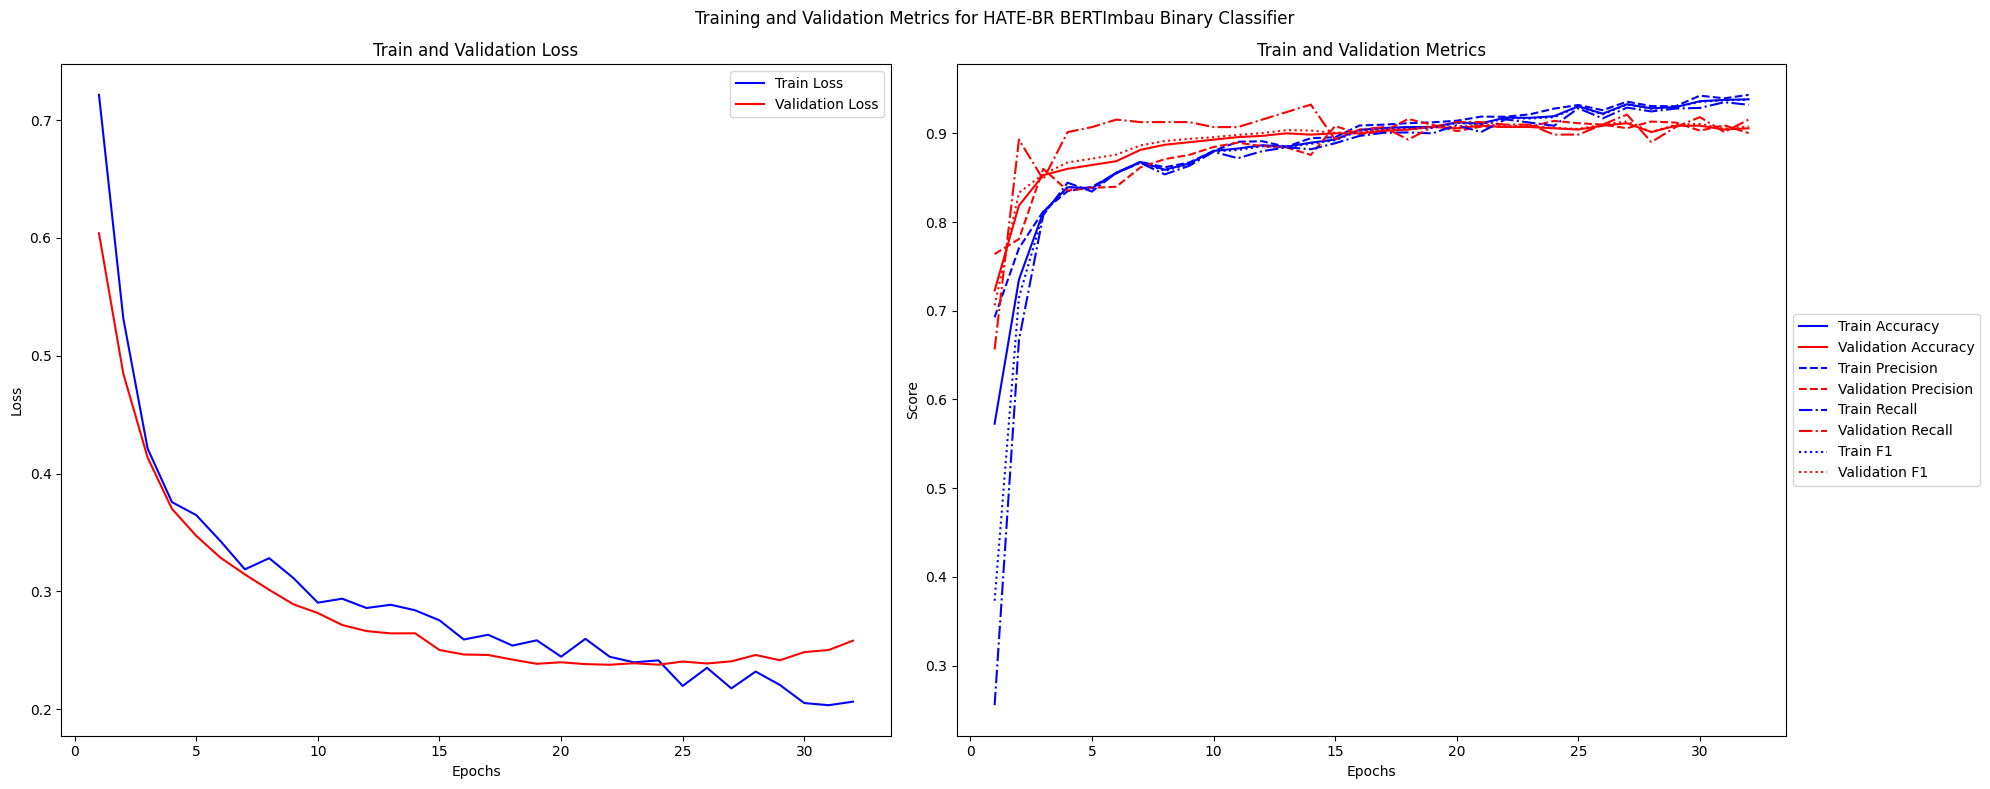

In [6]:
tokenizer = AutoTokenizer.from_pretrained(bert_timbau_model)
hatebr_binary_dataloader, HATEBR_BINARY_CLASSES, hatebr_binary_dataset = load_dataset(tokenizer, max_length=60, batch_size=8, multi_label=False, num_workers=4, dataset=HATE_BR_SPLITS)
print(f"HATE-BR Train Dataset Size: {len(hatebr_binary_dataloader['train'].dataset)}")

# Initialize the BERTImbau model for binary classification
print(f"HATE-BR Binary Model Class Names: {HATEBR_BINARY_CLASSES}")
hatebr_model = BERTMLCNNHateClassifier(num_classes=len(HATEBR_BINARY_CLASSES), model_name=BERT_MODELS["bert_timbau"], dropout_rate=0.5, freeze_bert_layers=0)

hatebr_binary_trainer = Trainer(
    model=hatebr_model,
    dataloader=hatebr_binary_dataloader,
    class_names=HATEBR_BINARY_CLASSES,
    criterion=torch.nn.BCEWithLogitsLoss(reduction='mean'),
    learning_rate=5e-6,
    epochs=50,
    patience=10,
    best_model_path="./bertimbau",
    best_model_filename="best_binary_bertcnn_hatebr_5e6_model.pth",
    freeze_bert_layers=-1,
    multilabel=False
)

# load the best model if it exists
best_model_path = os.path.join(hatebr_binary_trainer.best_model_path, hatebr_binary_trainer.best_model_filename)
if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}...")
    hatebr_binary_trainer.load_model(best_model_path)
    hatebr_binary_trainer.load_metrics_history(os.path.join('./metrics', 'metrics_hatebr_binary_bertcnn_5e6.csv'))
else:
    print(f"Best model not found at {best_model_path}. Training the model...")
    hatebr_binary_trainer.fit()
    hatebr_binary_trainer.save_metrics_history(os.path.join('./metrics', 'metrics_hatebr_binary_bertcnn_5e6.csv'))

history = hatebr_binary_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

hatebr_binary_trainer.plot_metrics(title="Training and Validation Metrics for HATE-BR BERTImbau Binary Classifier")

## HATE-BR BERTimbau Binary Classification

Loading dataset from https://raw.githubusercontent.com/isadorasalles/HateBRXplain/main/data/hatebr_and_rationales.csv...
Loading multilabel dataset...
Loaded dataset with 7000 samples.
Dataset columns: ['comentario', 'label final', 'normalized_text', 'rationales_offensive_1_normalized', 'rationales_offensive_2_normalized', 'rationales_offensive_1', 'links_post', 'rationales_offensive_2']
Dataset shape: (7000, 8)
Multilabel columns: ['label final', 'normalized_text', 'rationales_offensive_1_normalized', 'rationales_offensive_2_normalized', 'rationales_offensive_1', 'links_post', 'rationales_offensive_2']
Splitting test dataset into validation and test sets...
Dataset head:
                                                text  hate
0                             e ainda se diz cristão   1.0
1  sem noção ministério público tira esse idiota ...   1.0
2  queremos saber os nomes desses parlamentares b...   1.0
3  avante brasil bolsonaro melhor presidente do n...   0.0
4         lula e o seu m

Test Epoch 1/50: 100%|██████████| 132/132 [00:08<00:00, 16.12batch/s, loss=0.302]

Test loss: 0.3097752719609575 accuracy: 0.8819047619047619 precision: 0.9031007751937985 recall: 0.8629629629629629 f1: 0.8825757575757576


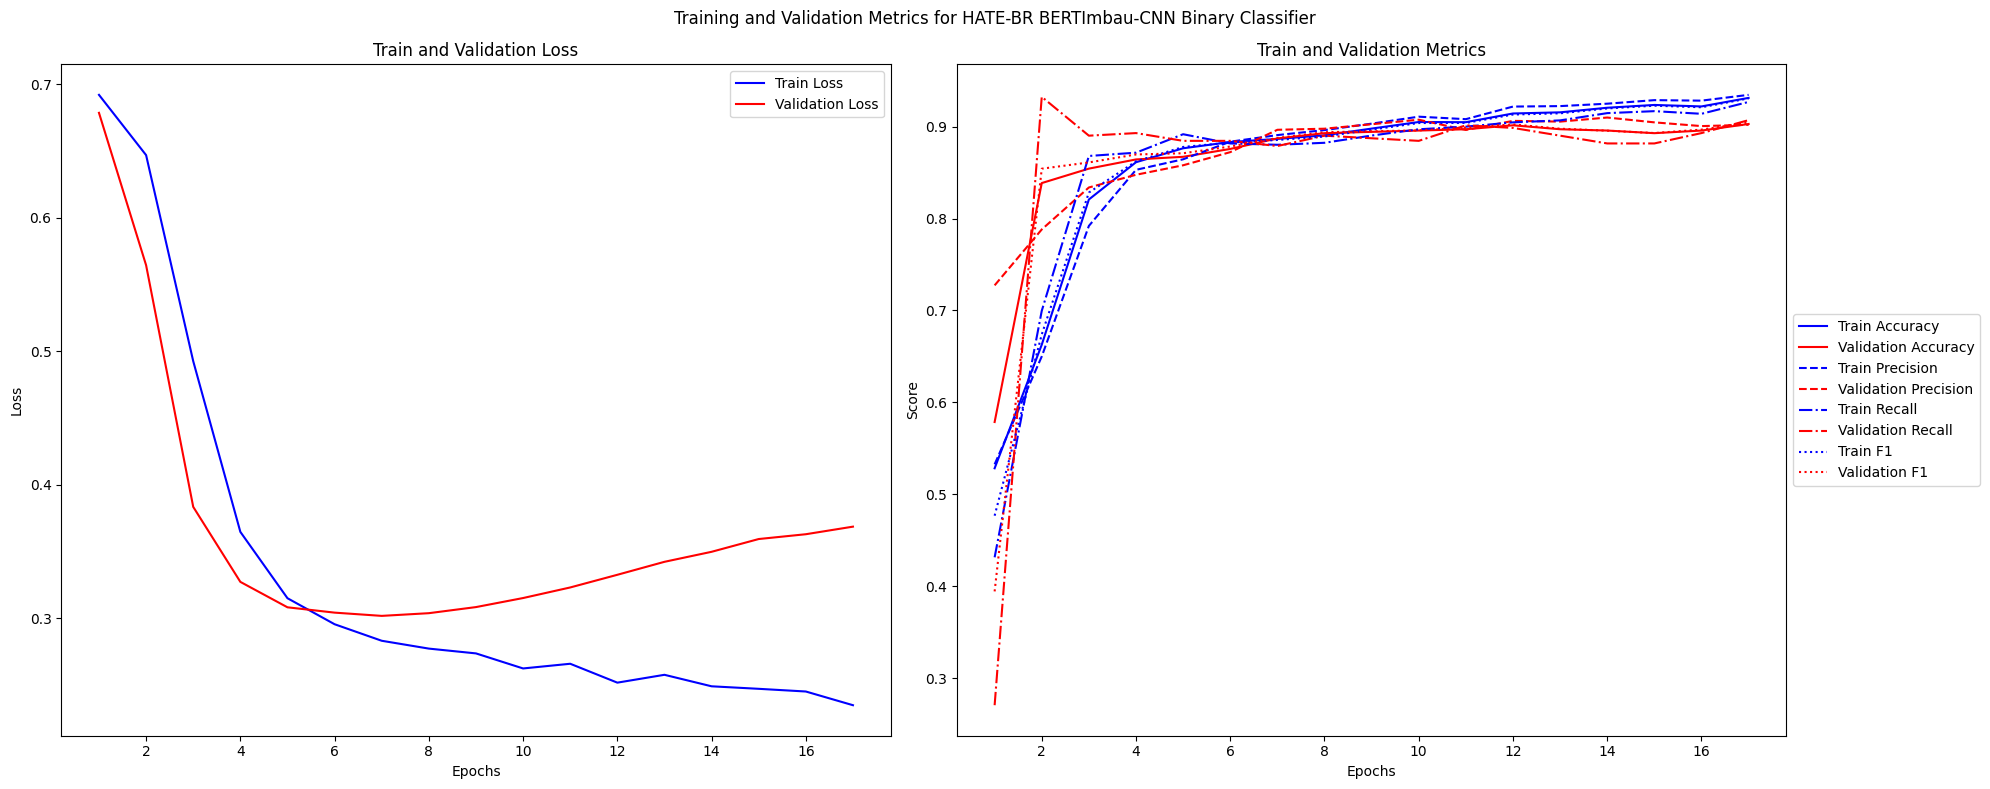

In [7]:
tokenizer = AutoTokenizer.from_pretrained(bert_timbau_model)
hatebr_binary_dataloader, HATEBR_BINARY_CLASSES, hatebr_binary_dataset = load_dataset(tokenizer, max_length=60, batch_size=8, multi_label=False, num_workers=4, dataset=HATE_BR_SPLITS)
print(f"HATE-BR Train Dataset Size: {len(hatebr_binary_dataloader['train'].dataset)}")

# Initialize the BERTImbau model for binary classification
print(f"HATE-BR Binary Model Class Names: {HATEBR_BINARY_CLASSES}")
hatebr_bert_model = BertClassifier(num_classes=len(HATEBR_BINARY_CLASSES), model_name=BERT_MODELS["bert_timbau"])

hatebr_bert_binary_trainer = Trainer(
    model=hatebr_bert_model,
    dataloader=hatebr_binary_dataloader,
    class_names=HATEBR_BINARY_CLASSES,
    criterion=torch.nn.BCEWithLogitsLoss(reduction='mean'),
    learning_rate=5e-6,
    epochs=50,
    patience=10,
    best_model_path="./bertimbau",
    best_model_filename="best_binary_bert_hatebr_5e6_model.pth",
    freeze_bert_layers=-1,
    multilabel=False
)

# load the best model if it exists
best_model_path = os.path.join(hatebr_bert_binary_trainer.best_model_path, hatebr_bert_binary_trainer.best_model_filename)
if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}...")
    hatebr_bert_binary_trainer.load_model(best_model_path)
    hatebr_bert_binary_trainer.load_metrics_history(os.path.join('./metrics', 'metrics_hatebr_bert_binary_5e6.csv'))
else:
    print(f"Best model not found at {best_model_path}. Training the model...")
    hatebr_bert_binary_trainer.fit()
    hatebr_bert_binary_trainer.save_metrics_history(os.path.join('./metrics', 'metrics_hatebr_bert_binary_5e6.csv'))

history = hatebr_bert_binary_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

hatebr_bert_binary_trainer.plot_metrics(title="Training and Validation Metrics for HATE-BR BERTImbau-CNN Binary Classifier")

## HATE-BR BERT-abaporu-CNN Binary Classification

Loading dataset from https://raw.githubusercontent.com/isadorasalles/HateBRXplain/main/data/hatebr_and_rationales.csv...
Loading multilabel dataset...
Loaded dataset with 7000 samples.
Dataset columns: ['comentario', 'label final', 'normalized_text', 'rationales_offensive_1_normalized', 'rationales_offensive_2_normalized', 'rationales_offensive_1', 'links_post', 'rationales_offensive_2']
Dataset shape: (7000, 8)
Multilabel columns: ['label final', 'normalized_text', 'rationales_offensive_1_normalized', 'rationales_offensive_2_normalized', 'rationales_offensive_1', 'links_post', 'rationales_offensive_2']
Splitting test dataset into validation and test sets...
Dataset head:
                                                text  hate
0                             e ainda se diz cristão   1.0
1  sem noção ministério público tira esse idiota ...   1.0
2  queremos saber os nomes desses parlamentares b...   1.0
3  avante brasil bolsonaro melhor presidente do n...   0.0
4         lula e o seu m

Test Epoch 1/50: 100%|██████████| 132/132 [00:08<00:00, 15.64batch/s, loss=0.181]

Test loss: 0.1802450782252532 accuracy: 0.9333333333333333 precision: 0.9368029739776952 recall: 0.9333333333333333 f1: 0.935064935064935


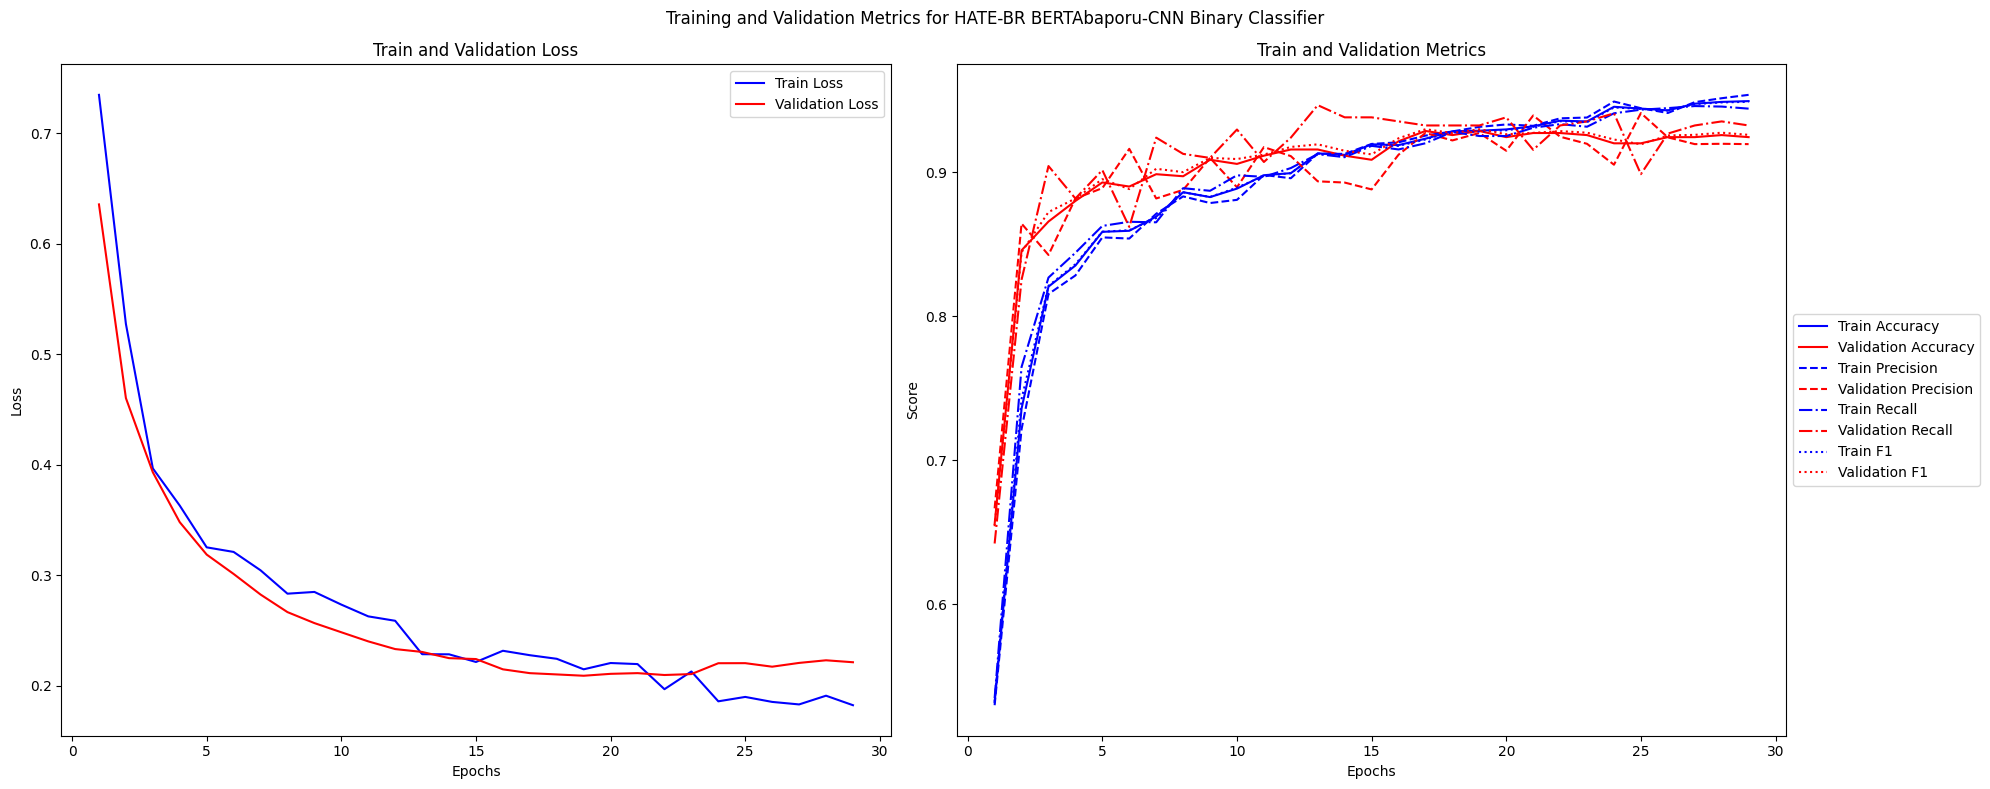

In [8]:
tokenizer = AutoTokenizer.from_pretrained(bert_abaporu_model)
hatebr_binary_dataloader, HATEBR_BINARY_CLASSES, hatebr_binary_dataset = load_dataset(tokenizer, max_length=60, batch_size=8, multi_label=False, num_workers=4, dataset=HATE_BR_SPLITS)
print(f"HATE-BR Train Dataset Size: {len(hatebr_binary_dataloader['train'].dataset)}")

# Initialize the BERTAbaporu model for binary classification
print(f"HATE-BR Binary Model Class Names: {HATEBR_BINARY_CLASSES}")
hatebr_model = BERTMLCNNHateClassifier(num_classes=len(HATEBR_BINARY_CLASSES), model_name=BERT_MODELS["bert_abaporu"], dropout_rate=0.5, freeze_bert_layers=0)

hatebr_binary_abaporu_cnn_trainer = Trainer(
    model=hatebr_model,
    dataloader=hatebr_binary_dataloader,
    class_names=HATEBR_BINARY_CLASSES,
    criterion=torch.nn.BCEWithLogitsLoss(reduction='mean'),
    learning_rate=5e-6,
    epochs=50,
    patience=10,
    best_model_path="./bertabaporu",
    best_model_filename="best_binary_bertcnn_hatebr_5e6_model.pth",
    freeze_bert_layers=-1,
    multilabel=False
)

# load the best model if it exists
best_model_path = os.path.join(hatebr_binary_abaporu_cnn_trainer.best_model_path, hatebr_binary_abaporu_cnn_trainer.best_model_filename)
if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}...")
    hatebr_binary_abaporu_cnn_trainer.load_model(best_model_path)
    hatebr_binary_abaporu_cnn_trainer.load_metrics_history(os.path.join('./metrics', 'metrics_hatebr_binary_abaporu_cnn_5e6.csv'))
else:
    print(f"Best model not found at {best_model_path}. Training the model...")
    hatebr_binary_abaporu_cnn_trainer.fit()
    hatebr_binary_abaporu_cnn_trainer.save_metrics_history(os.path.join('./metrics', 'metrics_hatebr_binary_abaporu_cnn_5e6.csv'))

history = hatebr_binary_abaporu_cnn_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

hatebr_binary_abaporu_cnn_trainer.plot_metrics(title="Training and Validation Metrics for HATE-BR BERTAbaporu-CNN Binary Classifier")

## HATE-BR BERT-abaporu Binary Classification

Loading dataset from https://raw.githubusercontent.com/isadorasalles/HateBRXplain/main/data/hatebr_and_rationales.csv...
Loading multilabel dataset...
Loaded dataset with 7000 samples.
Dataset columns: ['comentario', 'label final', 'normalized_text', 'rationales_offensive_1_normalized', 'rationales_offensive_2_normalized', 'rationales_offensive_1', 'links_post', 'rationales_offensive_2']
Dataset shape: (7000, 8)
Multilabel columns: ['label final', 'normalized_text', 'rationales_offensive_1_normalized', 'rationales_offensive_2_normalized', 'rationales_offensive_1', 'links_post', 'rationales_offensive_2']
Splitting test dataset into validation and test sets...
Dataset head:
                                                text  hate
0                             e ainda se diz cristão   1.0
1  sem noção ministério público tira esse idiota ...   1.0
2  queremos saber os nomes desses parlamentares b...   1.0
3  avante brasil bolsonaro melhor presidente do n...   0.0
4         lula e o seu m

Test Epoch 1/50: 100%|██████████| 132/132 [00:08<00:00, 15.94batch/s, loss=0.446]

Test loss: 0.45762568881565874 accuracy: 0.8019047619047619 precision: 0.8360323886639676 recall: 0.7648148148148148 f1: 0.7988394584139265


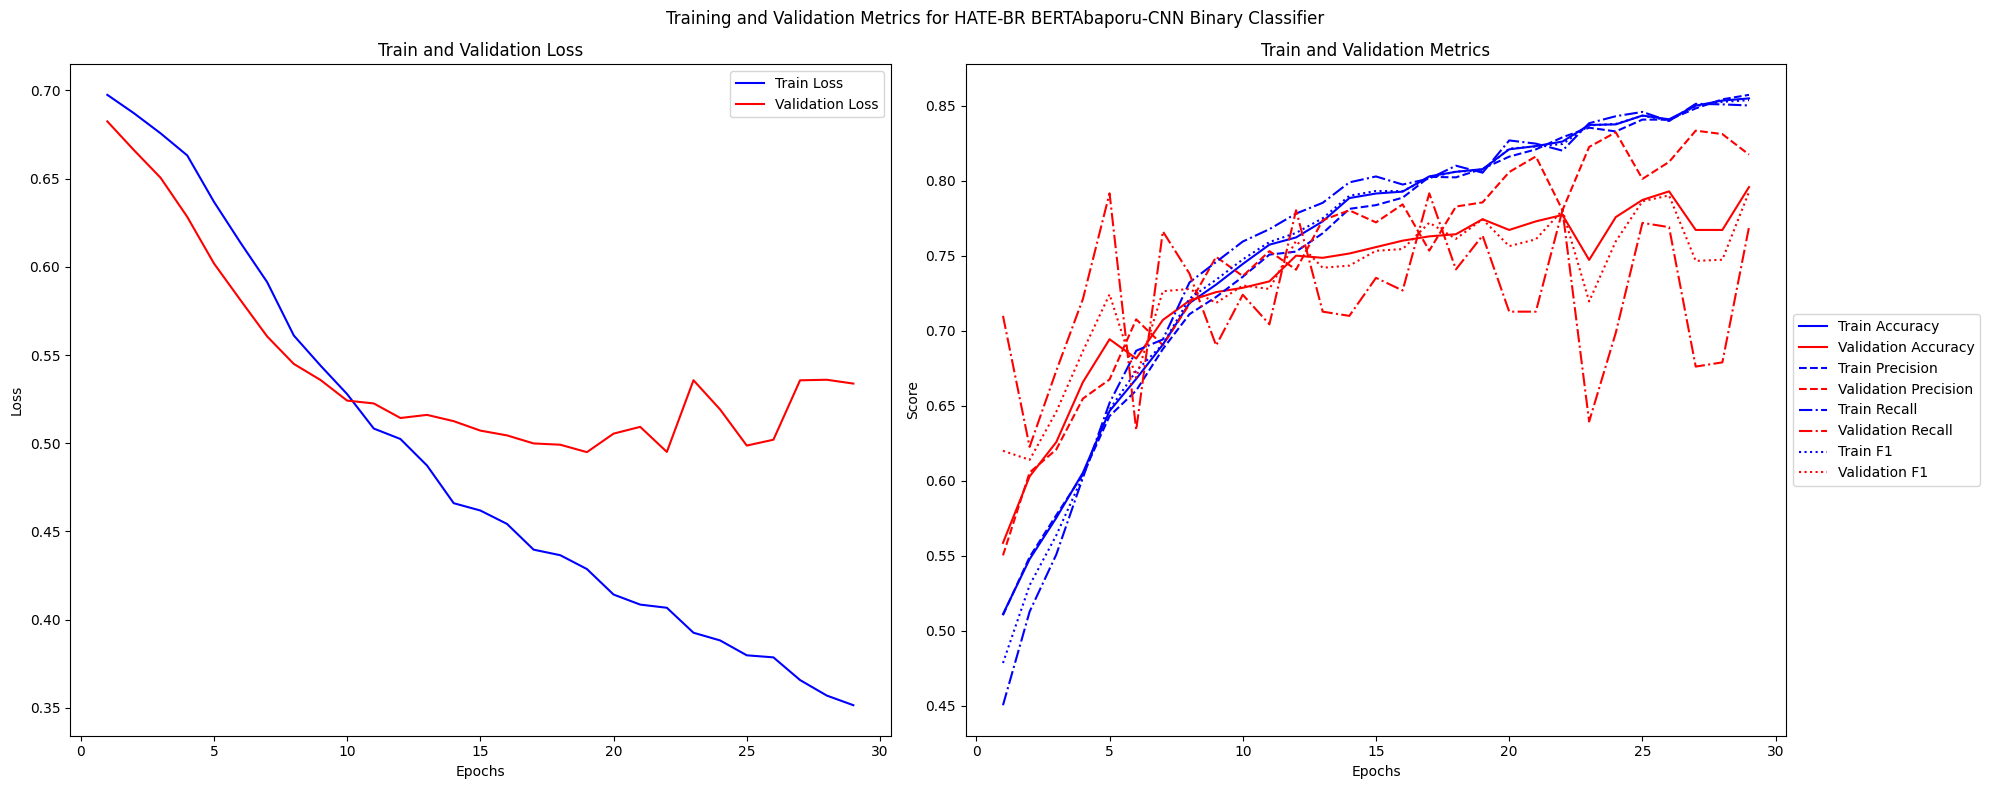

In [9]:
tokenizer = AutoTokenizer.from_pretrained(bert_timbau_model)
hatebr_binary_dataloader, HATEBR_BINARY_CLASSES, hatebr_binary_dataset = load_dataset(tokenizer, max_length=60, batch_size=8, multi_label=False, num_workers=4, dataset=HATE_BR_SPLITS)
print(f"HATE-BR Train Dataset Size: {len(hatebr_binary_dataloader['train'].dataset)}")

# Initialize the BERTImbau model for binary classification
print(f"HATE-BR Binary Model Class Names: {HATEBR_BINARY_CLASSES}")
hatebr_bert_abaporu_model = BertClassifier(num_classes=len(HATEBR_BINARY_CLASSES), model_name=BERT_MODELS["bert_abaporu"])

hatebr_bert_abaporu_binary_trainer = Trainer(
    model=hatebr_bert_abaporu_model,
    dataloader=hatebr_binary_dataloader,
    class_names=HATEBR_BINARY_CLASSES,
    criterion=torch.nn.BCEWithLogitsLoss(reduction='mean'),
    learning_rate=5e-6,
    epochs=50,
    patience=10,
    best_model_path="./bertabaporu",
    best_model_filename="best_binary_bert_hatebr_5e6_model.pth",
    freeze_bert_layers=-1,
    multilabel=False
)

# load the best model if it exists
best_model_path = os.path.join(hatebr_bert_abaporu_binary_trainer.best_model_path, hatebr_bert_abaporu_binary_trainer.best_model_filename)
if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}...")
    hatebr_bert_abaporu_binary_trainer.load_model(best_model_path)
    hatebr_bert_abaporu_binary_trainer.load_metrics_history(os.path.join('./metrics', 'metrics_hatebr_bert_abaporu_binary_5e6.csv'))
else:
    print(f"Best model not found at {best_model_path}. Training the model...")
    hatebr_bert_abaporu_binary_trainer.fit()
    hatebr_bert_abaporu_binary_trainer.save_metrics_history(os.path.join('./metrics', 'metrics_hatebr_bert_abaporu_binary_5e6.csv'))

history = hatebr_bert_abaporu_binary_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

hatebr_bert_abaporu_binary_trainer.plot_metrics(title="Training and Validation Metrics for HATE-BR BERTAbaporu-CNN Binary Classifier")

## Tupy-E Binary Training & Metrics

In [10]:
bertimbau_base_tokenizer = AutoTokenizer.from_pretrained(BERT_MODELS['tupye_binary_bert_base'])
tupye_binary_dataloader, TUPYE_BINARY_CLASSES, tupye_binary_dataset = load_dataset(bertimbau_base_tokenizer, max_length=224, batch_size=8, multi_label=False, num_workers=4, dataset=TUPYE_SPLITS)
print(f"Tupy-E Binary Train Dataset Size: {len(tupye_binary_dataloader['train'].dataset)}")

# Initialize the BERTImbau model for binary classification
print(f"Tupy-E Binary Model Class Names: {TUPYE_BINARY_CLASSES}")

Loading dataset from hf://datasets/Silly-Machine/TuPyE-Dataset/multilabel/multilabel_train.csv...
Loading multilabel dataset...
Loading dataset from hf://datasets/Silly-Machine/TuPyE-Dataset/multilabel/multilabel_test.csv...
Loading multilabel dataset...
Loaded dataset with 34934 samples.
Dataset columns: ['text', 'aggressive', 'hate', 'ageism', 'aporophobia', 'body_shame', 'capacitism', 'lgbtphobia', 'political', 'racism', 'religious_intolerance', 'misogyny', 'xenophobia', 'other', 'researcher', 'year', 'source']
Dataset shape: (34934, 17)
Multilabel columns: ['aggressive', 'hate', 'ageism', 'aporophobia', 'body_shame', 'capacitism', 'lgbtphobia', 'political', 'racism', 'religious_intolerance', 'misogyny', 'xenophobia', 'other', 'researcher', 'year', 'source']
Preprocessing datasets...
Maximum text length after preprocessing: 221
Dataset size after preprocessing: 34934 samples
Dataset size after removing NaN values: 34934 samples
Dataset size after removing empty texts: 34934 samples


### Tupy-E BERTimbau Base - CNN Binary Classification

Freezing ALL BERT layers
Total parameters: 109,365,889
Trainable parameters: 442,753 (0.4%)
Using device: mps
Number of classes: 1
Using loss function: BCEWithLogitsLoss
Loading best model from ./bertimbau/best_binary_bertcnn_tupye_5e6_model.pth...
Model loaded from ./bertimbau/best_binary_bertcnn_tupye_5e6_model.pth
History loaded from ./metrics/metrics_tupye_bertimbau_cnn_binary_5e6.csv


Test Epoch 1/50: 100%|██████████| 546/546 [00:47<00:00, 11.38batch/s, loss=0.0699]

Test loss: 0.06957872965860934 accuracy: 0.9805358369590108 precision: 0.9117647058823529 recall: 0.9207920792079208 f1: 0.916256157635468


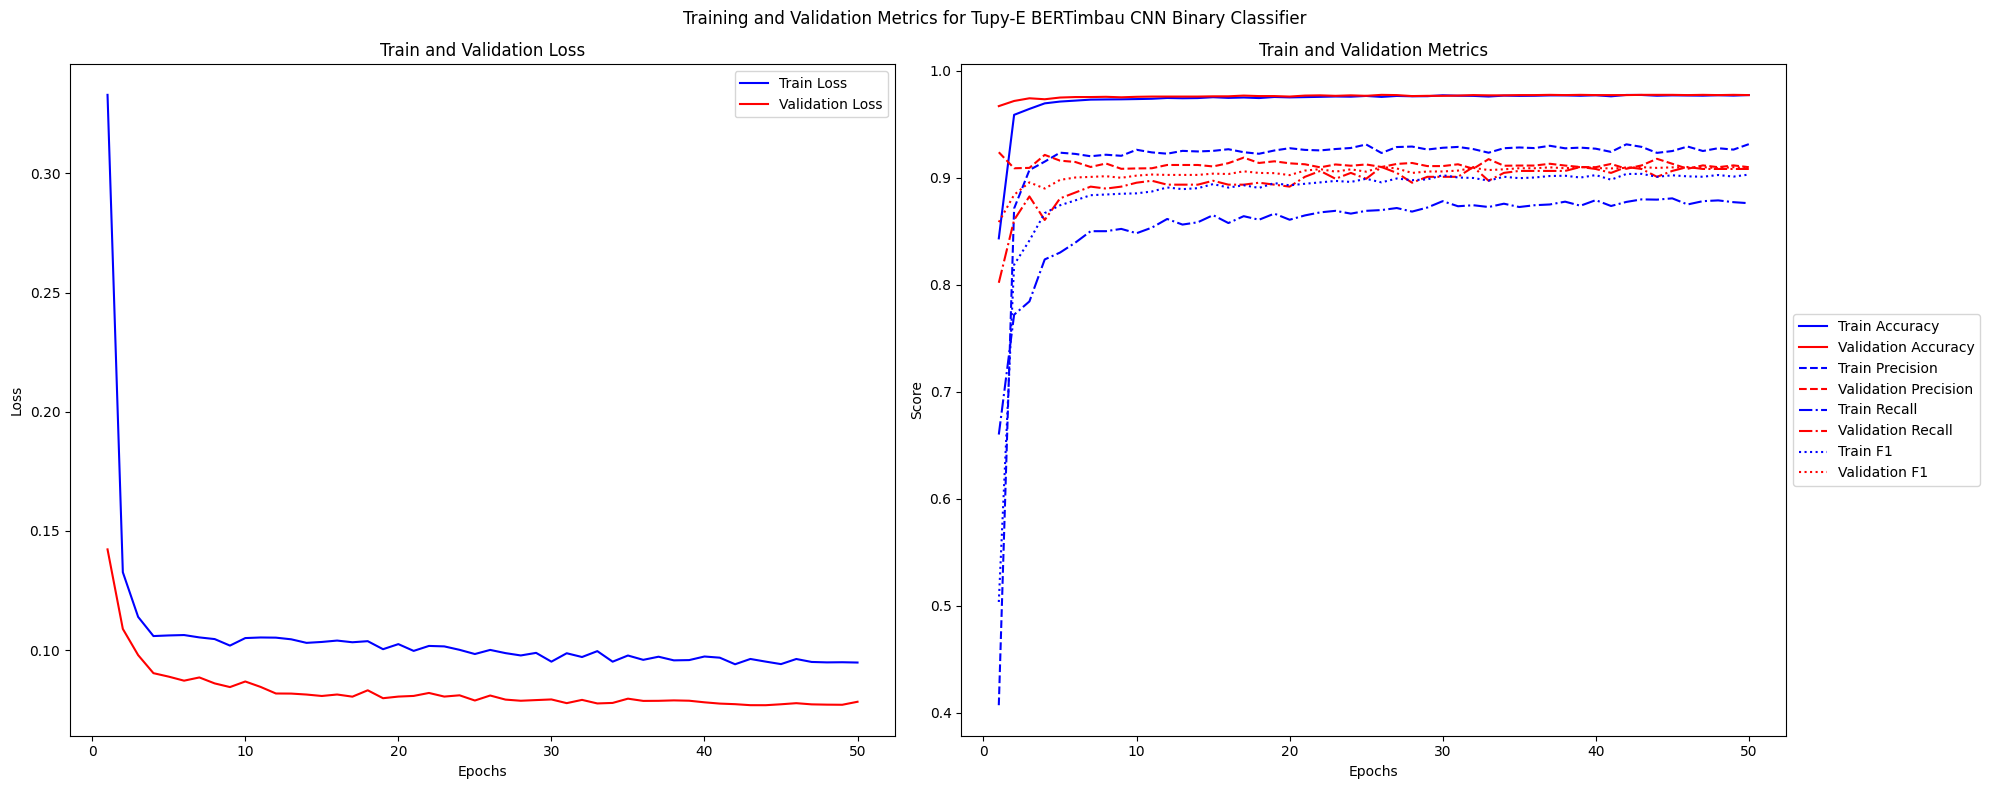

In [11]:
# Model was already trained with the dataset, so we can load it directly and parameters can be frozen keeping only the CNN layers trainable
tupye_bertimbau_cnn_base_model = BERTMLCNNHateClassifier(num_classes=len(TUPYE_BINARY_CLASSES), model_name=BERT_MODELS['tupye_binary_bert_base'], dropout_rate=0.5, freeze_bert_layers=-1)

tupye_bertimbau_cnn_binary_trainer = Trainer(
    model=tupye_bertimbau_cnn_base_model,
    dataloader=tupye_binary_dataloader,
    class_names=TUPYE_BINARY_CLASSES,
    criterion=torch.nn.BCEWithLogitsLoss(reduction='mean'),
    learning_rate=5e-6,
    epochs=50,
    patience=10,
    best_model_path="./bertimbau",
    best_model_filename="best_binary_bertcnn_tupye_5e6_model.pth",
    freeze_bert_layers=-1,
    multilabel=False
)

# load the best model if it exists
best_model_path = os.path.join(tupye_bertimbau_cnn_binary_trainer.best_model_path, tupye_bertimbau_cnn_binary_trainer.best_model_filename)
if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}...")
    tupye_bertimbau_cnn_binary_trainer.load_model(best_model_path)
    tupye_bertimbau_cnn_binary_trainer.load_metrics_history(os.path.join('./metrics', 'metrics_tupye_bertimbau_cnn_binary_5e6.csv'))
else:
    print(f"Best model not found at {best_model_path}. Training the model...")
    tupye_bertimbau_cnn_binary_trainer.fit()
    tupye_bertimbau_cnn_binary_trainer.save_metrics_history(os.path.join('./metrics', 'metrics_tupye_bertimbau_cnn_binary_5e6.csv'))

history = tupye_bertimbau_cnn_binary_trainer.test()
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

tupye_bertimbau_cnn_binary_trainer.plot_metrics(title="Training and Validation Metrics for Tupy-E BERTimbau CNN Binary Classifier")

# plot classification report
if 'report' in history and history['report']:
    report_df = pd.DataFrame(history['report']).transpose()
    print(report_df)

### Tupy-E BERTimbau Large - CNN Binary Classification

Freezing ALL BERT layers
Total parameters: 334,986,625
Trainable parameters: 590,209 (0.2%)
Using device: mps
Number of classes: 1
Using loss function: BCEWithLogitsLoss
Loading best model from ./bertimbau/best_binary_bertcnn_large_tupye_5e6_model.pth...
Model loaded from ./bertimbau/best_binary_bertcnn_large_tupye_5e6_model.pth
History loaded from ./metrics/metrics_tupye_bertimbau_large_cnn_binary_5e6.csv


Test Epoch 1/50: 100%|██████████| 546/546 [02:17<00:00,  3.97batch/s, loss=0.0824]

Test loss: 0.08216310235255504 accuracy: 0.9782459354247768 precision: 0.9288702928870293 recall: 0.8792079207920792 f1: 0.9033570701932858


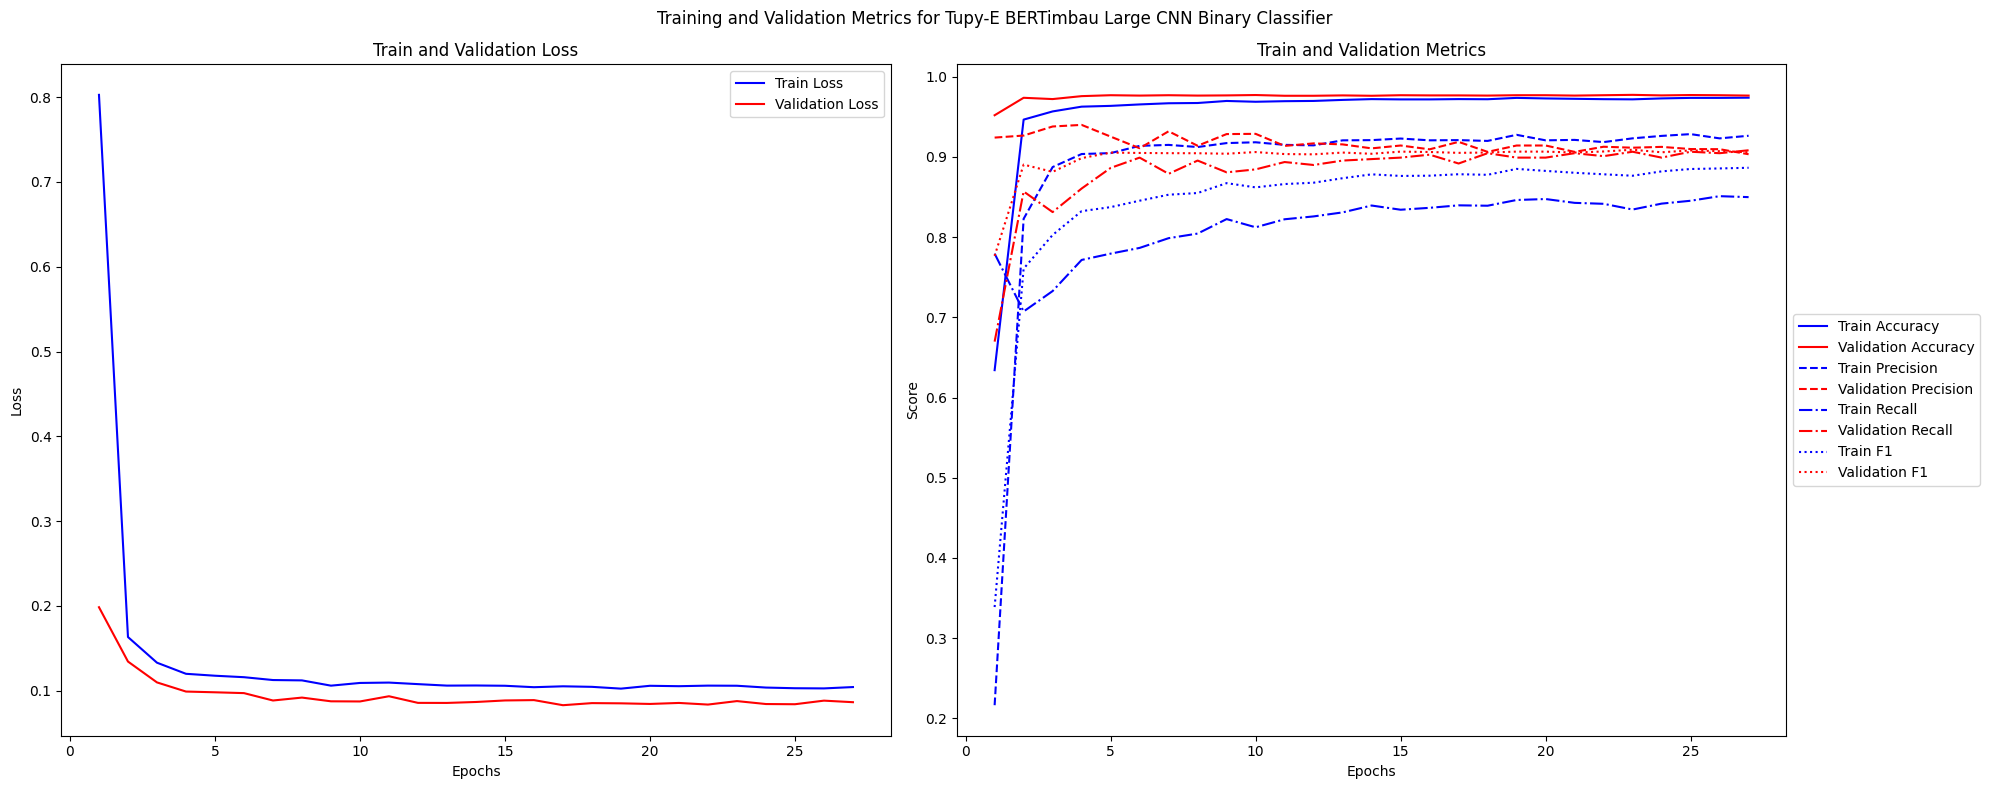

In [17]:
# Model was already trained with the dataset, so we can load it directly and parameters can be frozen keeping only the CNN layers trainable
tupye_bertimbau_cnn_large_model = BERTMLCNNHateClassifier(num_classes=len(TUPYE_BINARY_CLASSES), model_name=BERT_MODELS['tupye_binary_bert_large'], dropout_rate=0.5, freeze_bert_layers=-1)

tupye_bertimbau_large_cnn_binary_trainer = Trainer(
    model=tupye_bertimbau_cnn_large_model,
    dataloader=tupye_binary_dataloader,
    class_names=TUPYE_BINARY_CLASSES,
    criterion=torch.nn.BCEWithLogitsLoss(reduction='mean'),
    learning_rate=5e-6,
    epochs=50,
    patience=10,
    best_model_path="./bertimbau",
    best_model_filename="best_binary_bertcnn_large_tupye_5e6_model.pth",
    freeze_bert_layers=-1,
    multilabel=False
)

# load the best model if it exists
best_model_path = os.path.join(tupye_bertimbau_large_cnn_binary_trainer.best_model_path, tupye_bertimbau_large_cnn_binary_trainer.best_model_filename)
if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}...")
    tupye_bertimbau_large_cnn_binary_trainer.load_model(best_model_path)
    tupye_bertimbau_large_cnn_binary_trainer.load_metrics_history(os.path.join('./metrics', 'metrics_tupye_bertimbau_large_cnn_binary_5e6.csv'))
else:
    print(f"Best model not found at {best_model_path}. Training the model...")
    tupye_bertimbau_large_cnn_binary_trainer.fit()
    tupye_bertimbau_large_cnn_binary_trainer.save_metrics_history(os.path.join('./metrics', 'metrics_tupye_bertimbau_large_cnn_binary_5e6.csv'))

history = tupye_bertimbau_large_cnn_binary_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

tupye_bertimbau_large_cnn_binary_trainer.plot_metrics(title="Training and Validation Metrics for Tupy-E BERTimbau Large CNN Binary Classifier")

# plot classification report
if 'report' in history and history['report']:
    report_df = pd.DataFrame(history['report']).transpose()
    print(report_df)

## Tupy-E Multilabel Training & Metrics

In [10]:
bertimbau_tokenizer = AutoTokenizer.from_pretrained(BERT_MODELS["tupye_multilabel_bert_base"])
tupye_cnn_multilabel_dataloader, TUPYE_MULTILABEL_CLASSES, tupye_multilabel_dataset = load_dataset(bertimbau_tokenizer, max_length=224, batch_size=8, multi_label=True, num_workers=4, dataset=TUPYE_SPLITS)
print(f"Tupy-E Multilabel Train Dataset Size: {len(tupye_cnn_multilabel_dataloader['train'].dataset)}")

# Initialize the BERTImbau model for binary classification
print(f"Tupy-E Multilabel Model Class Names: {TUPYE_MULTILABEL_CLASSES}")

Loading dataset from hf://datasets/Silly-Machine/TuPyE-Dataset/multilabel/multilabel_train.csv...
Loading multilabel dataset...
Loading dataset from hf://datasets/Silly-Machine/TuPyE-Dataset/multilabel/multilabel_test.csv...
Loading multilabel dataset...
Loaded dataset with 34934 samples.
Dataset columns: ['text', 'aggressive', 'hate', 'ageism', 'aporophobia', 'body_shame', 'capacitism', 'lgbtphobia', 'political', 'racism', 'religious_intolerance', 'misogyny', 'xenophobia', 'other', 'researcher', 'year', 'source']
Dataset shape: (34934, 17)
Multilabel columns: ['aggressive', 'hate', 'ageism', 'aporophobia', 'body_shame', 'capacitism', 'lgbtphobia', 'political', 'racism', 'religious_intolerance', 'misogyny', 'xenophobia', 'other', 'researcher', 'year', 'source']
Preprocessing datasets...
Maximum text length after preprocessing: 221
Dataset size after preprocessing: 34934 samples
Dataset size after removing NaN values: 34934 samples
Dataset size after removing empty texts: 34934 samples


### Tupy-E BERTimbau Base - CNN Multilabel Classification

Freezing ALL BERT layers
Total parameters: 109,366,956
Trainable parameters: 443,820 (0.4%)
Using device: mps
Number of classes: 12
Using loss function: BCEWithLogitsLoss
Loading best model from ./bertimbau/best_multilabel_bertcnn_tupye_5e6_model.pth...
Model loaded from ./bertimbau/best_multilabel_bertcnn_tupye_5e6_model.pth
History loaded from ./metrics/metrics_tupye_bertimbau_cnn_multilabel_5e6.csv


Test Epoch 1/50: 100%|██████████| 546/546 [00:54<00:00, 10.07batch/s, loss=0.0686]

Test loss: 0.06874878717340775 accuracy: 0.8319212273872223 precision: 0.9013815739256545 recall: 0.8922219677887183 f1: 0.8897565071368597


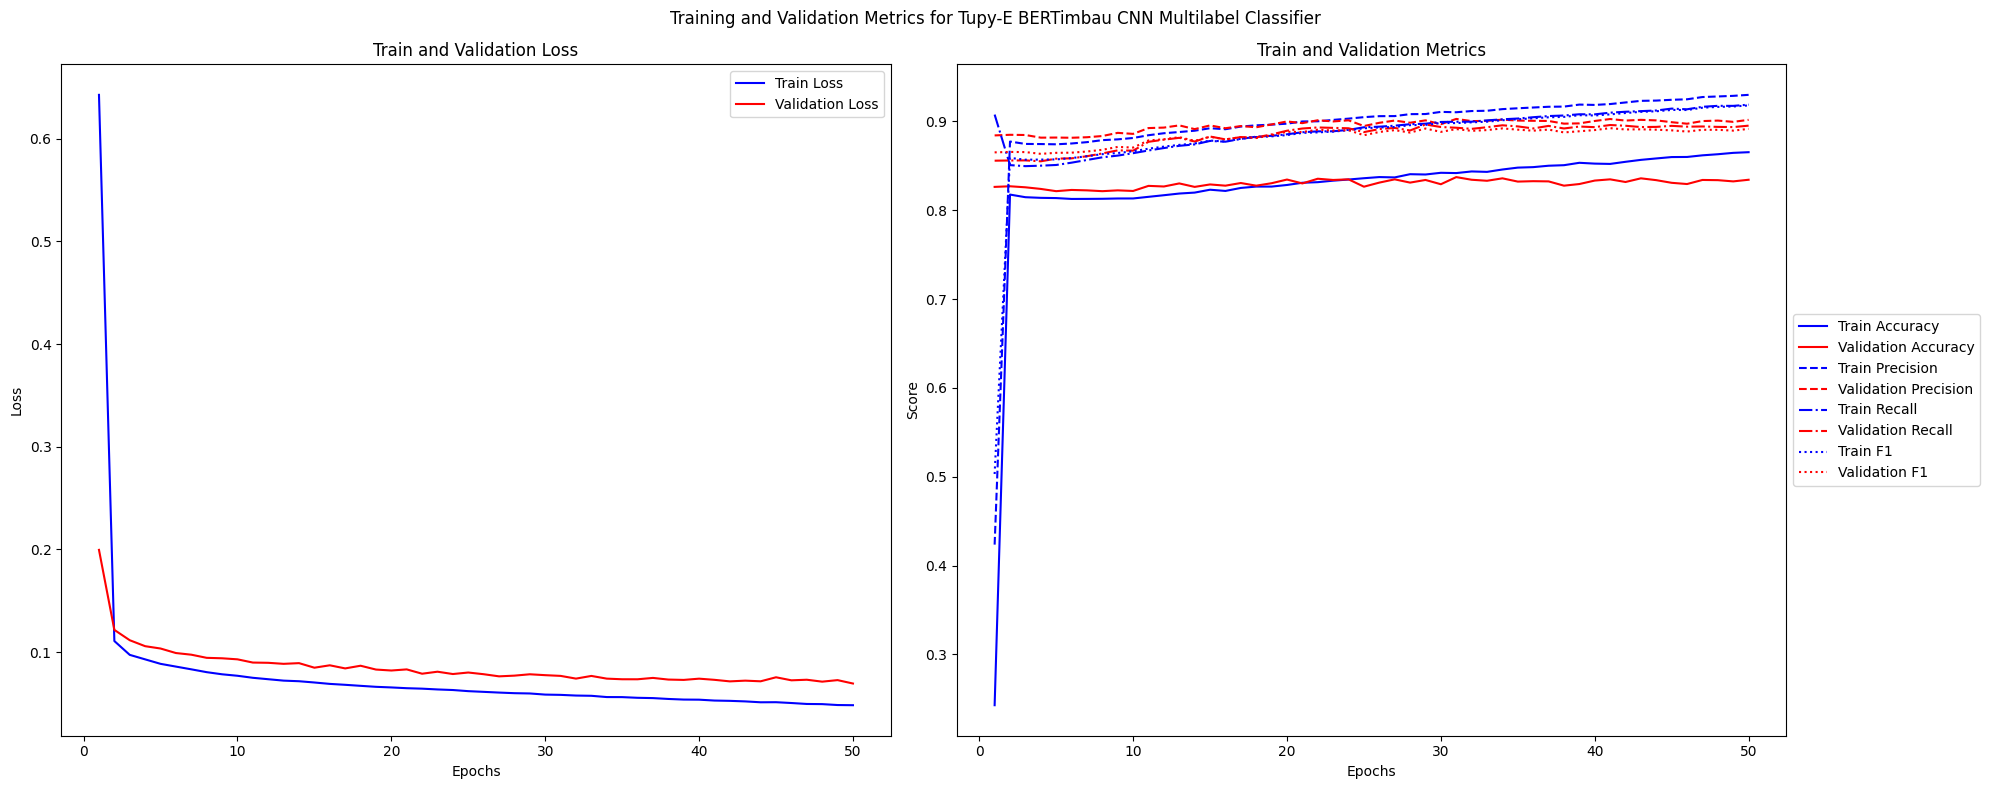

                       precision    recall  f1-score  support
ageism                  0.000000  0.000000  0.000000      6.0
aporophobia             0.000000  0.000000  0.000000      8.0
body_shame              0.714286  0.476190  0.571429     21.0
capacitism              0.000000  0.000000  0.000000      7.0
lgbtphobia              0.754098  0.647887  0.696970     71.0
political               0.706897  0.341667  0.460674    120.0
racism                  0.500000  0.107143  0.176471     28.0
religious_intolerance   0.000000  0.000000  0.000000      9.0
misogyny                0.737864  0.460606  0.567164    165.0
xenophobia              0.650000  0.260000  0.371429     50.0
other                   0.554896  0.434884  0.487614    430.0
not_hate                0.935476  0.964785  0.949904   3862.0
micro avg               0.895242  0.858698  0.876589   4777.0
macro avg               0.462793  0.307764  0.356805   4777.0
weighted avg            0.873567  0.858698  0.860805   4777.0
samples 

In [14]:
# Model was already trained with the dataset, so we can load it directly and parameters can be frozen keeping only the CNN layers trainable
tupye_bertcnn_timbau_model = BERTMLCNNHateClassifier(num_classes=len(TUPYE_MULTILABEL_CLASSES), model_name=BERT_MODELS["tupye_multilabel_bert_base"], dropout_rate=0.5, freeze_bert_layers=-1)

tupye_bertimbau_cnn_multilabel_trainer = Trainer(
    model=tupye_bertcnn_timbau_model,
    dataloader=tupye_cnn_multilabel_dataloader,
    class_names=TUPYE_MULTILABEL_CLASSES,
    criterion=torch.nn.BCEWithLogitsLoss(reduction='mean'),
    learning_rate=5e-6,
    epochs=50,
    patience=10,
    best_model_path="./bertimbau",
    best_model_filename="best_multilabel_bertcnn_tupye_5e6_model.pth",
    freeze_bert_layers=-1,
    multilabel=True
)

# load the best model if it exists
best_model_path = os.path.join(tupye_bertimbau_cnn_multilabel_trainer.best_model_path, tupye_bertimbau_cnn_multilabel_trainer.best_model_filename)
if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}...")
    tupye_bertimbau_cnn_multilabel_trainer.load_model(best_model_path)
    tupye_bertimbau_cnn_multilabel_trainer.load_metrics_history(os.path.join('./metrics', 'metrics_tupye_bertimbau_cnn_multilabel_5e6.csv'))
else:
    print(f"Best model not found at {best_model_path}. Training the model...")
    tupye_bertimbau_cnn_multilabel_trainer.fit()
    tupye_bertimbau_cnn_multilabel_trainer.save_metrics_history(os.path.join('./metrics', 'metrics_tupye_bertimbau_cnn_multilabel_5e6.csv'))

history = tupye_bertimbau_cnn_multilabel_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

tupye_bertimbau_cnn_multilabel_trainer.plot_metrics(title="Training and Validation Metrics for Tupy-E BERTimbau CNN Multilabel Classifier")

# plot classification report
if 'report' in history and history['report']:
    report_df = pd.DataFrame(history['report']).transpose()
    print(report_df)

## Tupy-E BERTimbau Base - CNN Multilabel Classification 224 Length

Freezing ALL BERT layers
Total parameters: 109,366,956
Trainable parameters: 443,820 (0.4%)
Using device: mps
Number of classes: 12
Using loss function: BCEWithLogitsLoss
Loading best model from ./bertimbau/best_multilabel_bertcnn_tupye_5e6_224_length_model.pth...
Model loaded from ./bertimbau/best_multilabel_bertcnn_tupye_5e6_224_length_model.pth
History loaded from ./metrics/metrics_tupye_bertimbau_cnn_multilabel_5e6_224_length.csv


Test Epoch 1/50: 100%|██████████| 1092/1092 [01:46<00:00, 10.23batch/s, loss=0.0566]

Test loss: 0.05664125380307545 accuracy: 0.9046256010991527 precision: 0.961854056942218 recall: 0.952083810396153 f1: 0.9513739409205403


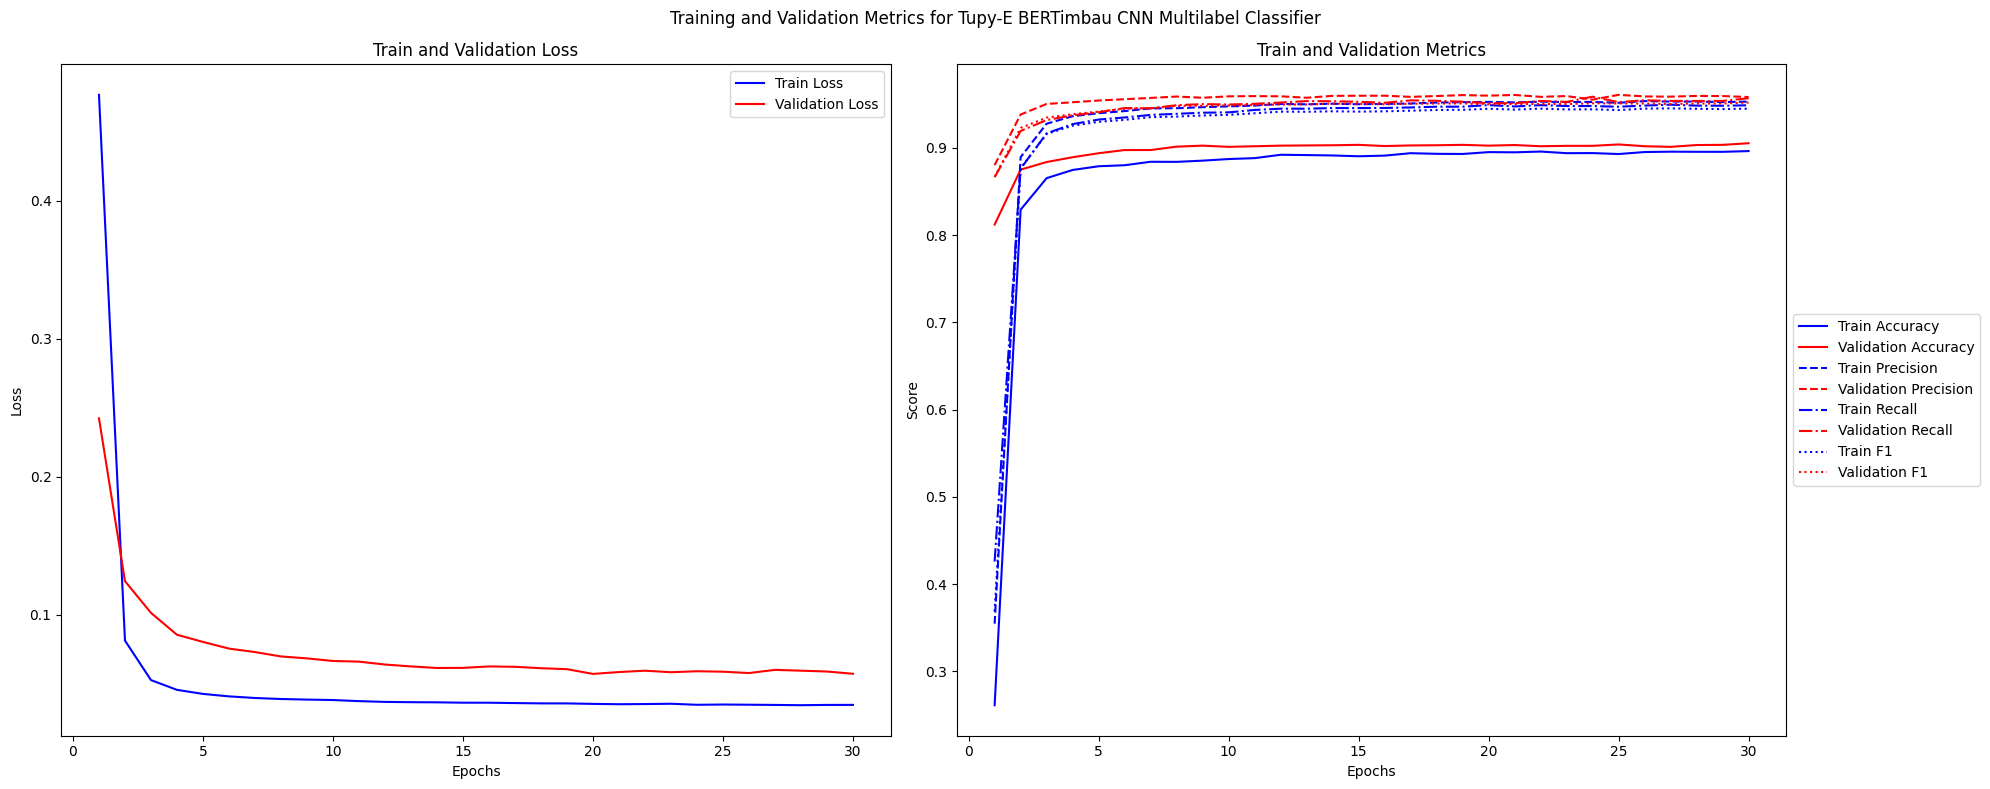

                       precision    recall  f1-score  support
ageism                  0.000000  0.000000  0.000000     12.0
aporophobia             0.000000  0.000000  0.000000     14.0
body_shame              0.786885  0.761905  0.774194     63.0
capacitism              0.000000  0.000000  0.000000     11.0
lgbtphobia              0.865385  0.906040  0.885246    149.0
political               0.865306  0.921739  0.892632    230.0
racism                  0.615385  0.571429  0.592593     56.0
religious_intolerance   0.875000  0.411765  0.560000     17.0
misogyny                0.856707  0.838806  0.847662    335.0
xenophobia              0.835616  0.693182  0.757764     88.0
other                   0.862791  0.844141  0.853364    879.0
not_hate                0.975312  0.956273  0.965699   7684.0
micro avg               0.951594  0.929545  0.940440   9538.0
macro avg               0.628199  0.575440  0.594096   9538.0
weighted avg            0.947798  0.929545  0.938338   9538.0
samples 

In [13]:
# Model was already trained with the dataset, so we can load it directly and parameters can be frozen keeping only the CNN layers trainable
tupye_bertcnn_timbau_model = BERTMLCNNHateClassifier(num_classes=len(TUPYE_MULTILABEL_CLASSES), model_name=BERT_MODELS["tupye_multilabel_bert_base"], dropout_rate=0.5, freeze_bert_layers=-1)

tupye_bertimbau_cnn_multilabel_224_length_trainer = Trainer(
    model=tupye_bertcnn_timbau_model,
    dataloader=tupye_cnn_multilabel_dataloader,
    class_names=TUPYE_MULTILABEL_CLASSES,
    criterion=torch.nn.BCEWithLogitsLoss(reduction='mean'),
    learning_rate=5e-6,
    epochs=50,
    patience=5,
    best_model_path="./bertimbau",
    best_model_filename="best_multilabel_bertcnn_tupye_5e6_224_length_model.pth",
    freeze_bert_layers=-1,
    multilabel=True
)

# load the best model if it exists
best_model_path = os.path.join(tupye_bertimbau_cnn_multilabel_224_length_trainer.best_model_path, tupye_bertimbau_cnn_multilabel_224_length_trainer.best_model_filename)
if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}...")
    tupye_bertimbau_cnn_multilabel_224_length_trainer.load_model(best_model_path)
    tupye_bertimbau_cnn_multilabel_224_length_trainer.load_metrics_history(os.path.join('./metrics', 'metrics_tupye_bertimbau_cnn_multilabel_5e6_224_length.csv'))
else:
    print(f"Best model not found at {best_model_path}. Training the model...")
    tupye_bertimbau_cnn_multilabel_224_length_trainer.fit()
    tupye_bertimbau_cnn_multilabel_224_length_trainer.save_metrics_history(os.path.join('./metrics', 'metrics_tupye_bertimbau_cnn_multilabel_5e6_224_length.csv'))

history = tupye_bertimbau_cnn_multilabel_224_length_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

tupye_bertimbau_cnn_multilabel_224_length_trainer.plot_metrics(title="Training and Validation Metrics for Tupy-E BERTimbau CNN Multilabel Classifier")

# plot classification report
if 'report' in history and history['report']:
    report_df = pd.DataFrame(history['report']).transpose()
    print(report_df)

### Tupy-E BERTimbau Large - CNN Multilabel Classification

Freezing ALL BERT layers
Total parameters: 334,987,692
Trainable parameters: 591,276 (0.2%)
Using device: mps
Number of classes: 12
Using loss function: BCEWithLogitsLoss
Loading best model from ./bertimbau/best_multilabel_bertcnn_large_tupye_5e6_model.pth...
Model loaded from ./bertimbau/best_multilabel_bertcnn_large_tupye_5e6_model.pth
History loaded from ./metrics/metrics_tupye_large_bertimbau_cnn_multilabel_5e6.csv


Test Epoch 1/50: 100%|██████████| 546/546 [02:20<00:00,  3.88batch/s, loss=0.0526]

Test loss: 0.05286600014310835 accuracy: 0.9102358598580261 precision: 0.9638195557591024 recall: 0.9601175482787573 f1: 0.9564231738035264


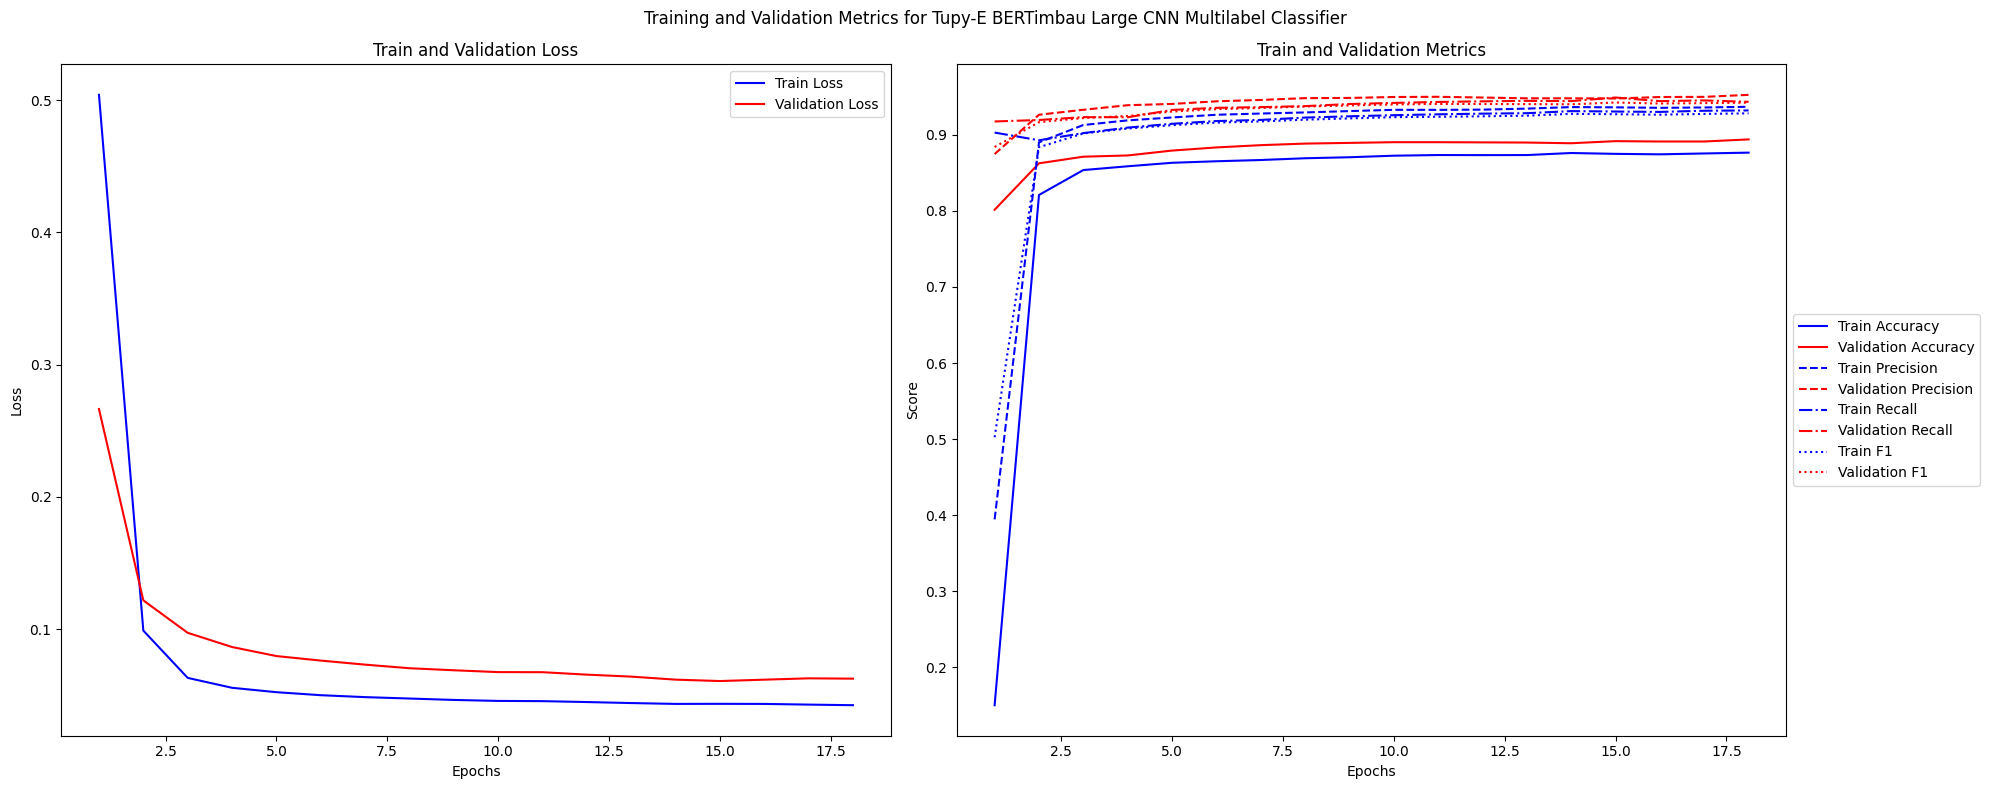

                       precision    recall  f1-score  support
ageism                  0.000000  0.000000  0.000000      6.0
aporophobia             0.000000  0.000000  0.000000      8.0
body_shame              0.950000  0.904762  0.926829     21.0
capacitism              0.000000  0.000000  0.000000      7.0
lgbtphobia              0.914286  0.901408  0.907801     71.0
political               0.948980  0.775000  0.853211    120.0
racism                  0.842105  0.571429  0.680851     28.0
religious_intolerance   0.000000  0.000000  0.000000      9.0
misogyny                0.937500  0.818182  0.873786    165.0
xenophobia              0.911765  0.620000  0.738095     50.0
other                   0.901914  0.876744  0.889151    430.0
not_hate                0.964515  0.971258  0.967875   3862.0
micro avg               0.956095  0.939083  0.947513   4777.0
macro avg               0.614255  0.536565  0.569800   4777.0
weighted avg            0.949420  0.939083  0.943419   4777.0
samples 

In [15]:
# Model was already trained with the dataset, so we can load it directly and parameters can be frozen keeping only the CNN layers trainable
tupye_large_bertcnn_timbau_model = BERTMLCNNHateClassifier(num_classes=len(TUPYE_MULTILABEL_CLASSES), model_name=BERT_MODELS["tupye_multilabel_bert_large"], dropout_rate=0.5, freeze_bert_layers=-1)

tupye_large_bertimbau_cnn_multilabel_trainer = Trainer(
    model=tupye_large_bertcnn_timbau_model,
    dataloader=tupye_cnn_multilabel_dataloader,
    class_names=TUPYE_MULTILABEL_CLASSES,
    criterion=torch.nn.BCEWithLogitsLoss(reduction='mean'),
    learning_rate=5e-6,
    epochs=50,
    patience=3,
    best_model_path="./bertimbau",
    best_model_filename="best_multilabel_bertcnn_large_tupye_5e6_model.pth",
    freeze_bert_layers=-1,
    multilabel=True
)

# load the best model if it exists
best_model_path = os.path.join(tupye_large_bertimbau_cnn_multilabel_trainer.best_model_path, tupye_large_bertimbau_cnn_multilabel_trainer.best_model_filename)
if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}...")
    tupye_large_bertimbau_cnn_multilabel_trainer.load_model(best_model_path)
    tupye_large_bertimbau_cnn_multilabel_trainer.load_metrics_history(os.path.join('./metrics', 'metrics_tupye_large_bertimbau_cnn_multilabel_5e6.csv'))
else:
    print(f"Best model not found at {best_model_path}. Training the model...")
    tupye_large_bertimbau_cnn_multilabel_trainer.fit()
    tupye_large_bertimbau_cnn_multilabel_trainer.save_metrics_history(os.path.join('./metrics', 'metrics_tupye_large_bertimbau_cnn_multilabel_5e6.csv'))

history = tupye_large_bertimbau_cnn_multilabel_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

tupye_large_bertimbau_cnn_multilabel_trainer.plot_metrics(title="Training and Validation Metrics for Tupy-E BERTimbau Large CNN Multilabel Classifier")

# plot classification report
if 'report' in history and history['report']:
    report_df = pd.DataFrame(history['report']).transpose()
    print(report_df)

## Tupy-E BERTimbau Large - CNN Multilabel Classification 224 Length

Freezing ALL BERT layers
Total parameters: 334,987,692
Trainable parameters: 591,276 (0.2%)
Using device: mps
Number of classes: 12
Using loss function: BCEWithLogitsLoss
Loading best model from ./bertimbau/best_multilabel_bertcnn_large_tupye_5e6_model_224_length.pth...
Model loaded from ./bertimbau/best_multilabel_bertcnn_large_tupye_5e6_model_224_length.pth
History loaded from ./metrics/metrics_tupye_large_bertimbau_cnn_multilabel_5e6_224_length.csv


Test Epoch 1/50: 100%|██████████| 1092/1092 [04:47<00:00,  3.80batch/s, loss=0.0426]

Test loss: 0.04261005211505534 accuracy: 0.9192809709182506 precision: 0.970460270208381 recall: 0.9644492786810167 f1: 0.9622547897107092


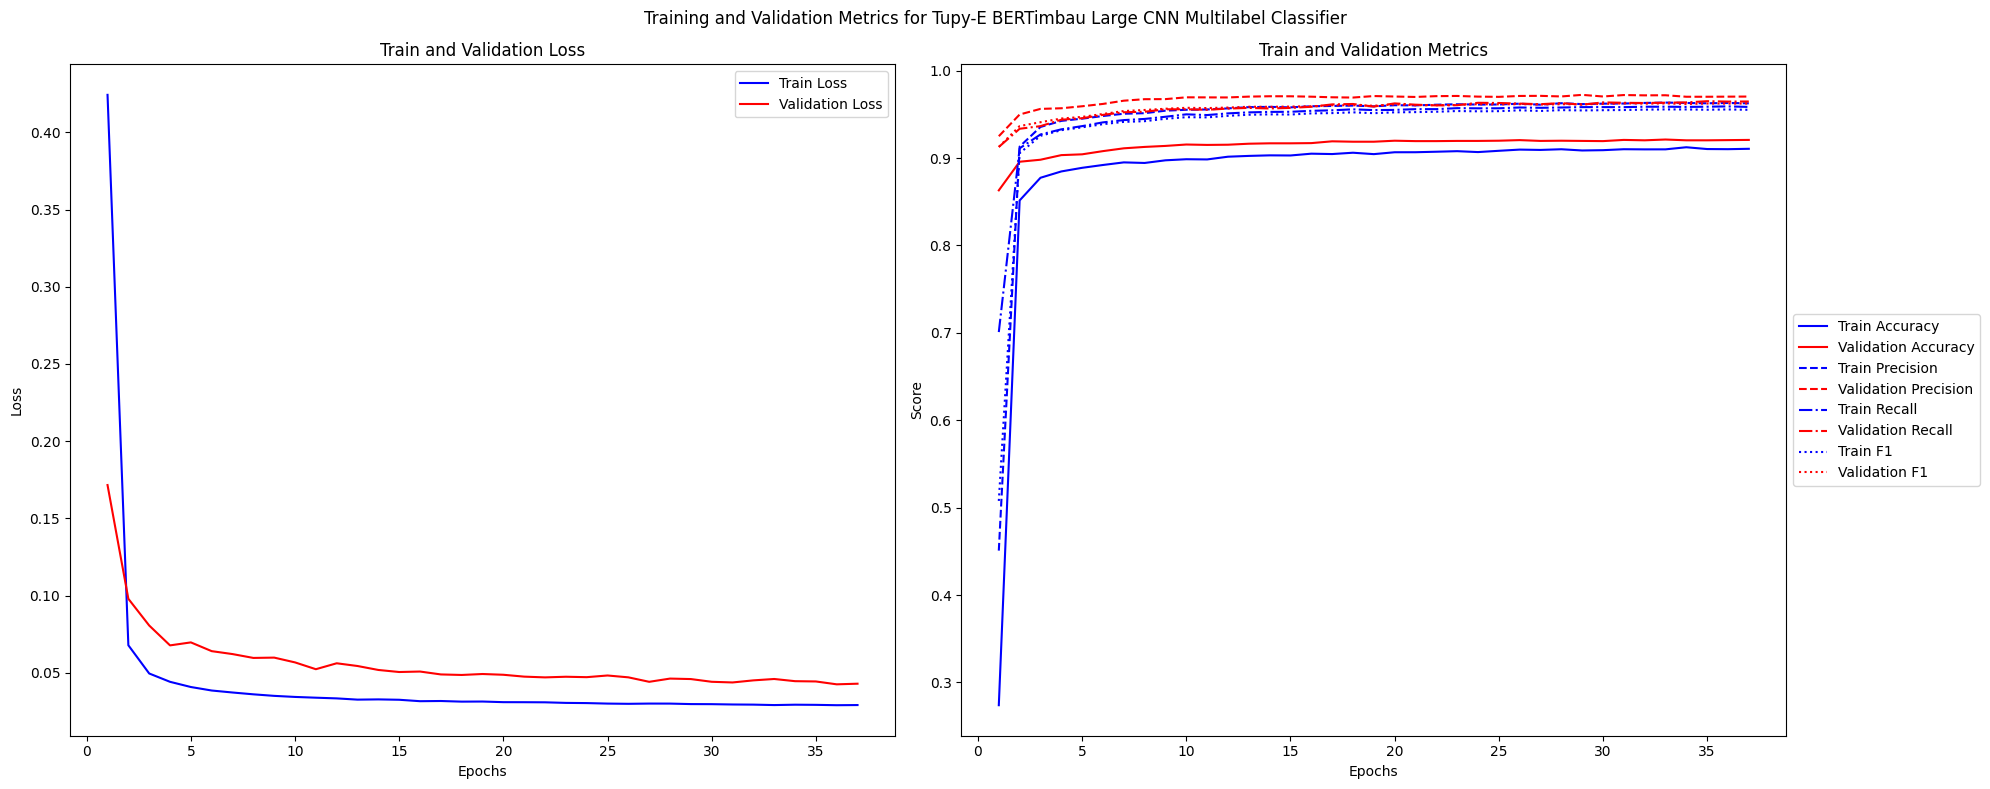

                       precision    recall  f1-score  support
ageism                  0.750000  0.500000  0.600000     12.0
aporophobia             0.909091  0.714286  0.800000     14.0
body_shame              0.859375  0.873016  0.866142     63.0
capacitism              0.800000  0.727273  0.761905     11.0
lgbtphobia              0.951049  0.912752  0.931507    149.0
political               0.890351  0.882609  0.886463    230.0
racism                  0.741935  0.821429  0.779661     56.0
religious_intolerance   0.916667  0.647059  0.758621     17.0
misogyny                0.920128  0.859701  0.888889    335.0
xenophobia              0.870130  0.761364  0.812121     88.0
other                   0.899083  0.891923  0.895488    879.0
not_hate                0.974241  0.964732  0.969463   7684.0
micro avg               0.959401  0.946425  0.952869   9538.0
macro avg               0.873504  0.796345  0.829188   9538.0
weighted avg            0.959264  0.946425  0.952644   9538.0
samples 

In [12]:
# Model was already trained with the dataset, so we can load it directly and parameters can be frozen keeping only the CNN layers trainable
tupye_large_bertcnn_timbau_model = BERTMLCNNHateClassifier(num_classes=len(TUPYE_MULTILABEL_CLASSES), model_name=BERT_MODELS["tupye_multilabel_bert_large"], dropout_rate=0.5, freeze_bert_layers=-1)

tupye_large_bertimbau_cnn_multilabel_224_length_trainer = Trainer(
    model=tupye_large_bertcnn_timbau_model,
    dataloader=tupye_cnn_multilabel_dataloader,
    class_names=TUPYE_MULTILABEL_CLASSES,
    criterion=torch.nn.BCEWithLogitsLoss(reduction='mean'),
    learning_rate=5e-6,
    epochs=50,
    patience=5,
    best_model_path="./bertimbau",
    best_model_filename="best_multilabel_bertcnn_large_tupye_5e6_model_224_length.pth",
    freeze_bert_layers=-1,
    multilabel=True
)

# load the best model if it exists
best_model_path = os.path.join(tupye_large_bertimbau_cnn_multilabel_224_length_trainer.best_model_path, tupye_large_bertimbau_cnn_multilabel_224_length_trainer.best_model_filename)
if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}...")
    tupye_large_bertimbau_cnn_multilabel_224_length_trainer.load_model(best_model_path)
    tupye_large_bertimbau_cnn_multilabel_224_length_trainer.load_metrics_history(os.path.join('./metrics', 'metrics_tupye_large_bertimbau_cnn_multilabel_5e6_224_length.csv'))
else:
    print(f"Best model not found at {best_model_path}. Training the model...")
    tupye_large_bertimbau_cnn_multilabel_224_length_trainer.fit()
    tupye_large_bertimbau_cnn_multilabel_224_length_trainer.save_metrics_history(os.path.join('./metrics', 'metrics_tupye_large_bertimbau_cnn_multilabel_5e6_224_length.csv'))

history = tupye_large_bertimbau_cnn_multilabel_224_length_trainer.evaluate(testing=True)
print(f'Test loss: {history["loss"]} accuracy: {history["accuracy"]} precision: {history["precision"]} recall: {history["recall"]} f1: {history["f1"]}')

tupye_large_bertimbau_cnn_multilabel_224_length_trainer.plot_metrics(title="Training and Validation Metrics for Tupy-E BERTimbau Large CNN Multilabel Classifier")

# plot classification report
if 'report' in history and history['report']:
    report_df = pd.DataFrame(history['report']).transpose()
    print(report_df)